In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
sys.path.append('..')
from load_data import load_masks, split_train_val_test
from unet import UNet
from config import *

In [2]:
masks, scores = load_masks(verse2019_dir)

Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/masks_bodies...


  0%|          | 0/120 [00:00<?, ?it/s]

In [3]:
# make train/val split
train_set, val_set, test_set = split_train_val_test(masks, scores, patch_size)

Available cases: 120 
train: 96, val: 12, test: 12
Extracting patches...


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 732, val: 71, test: 70


In [4]:
# initialize test data loaders
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [5]:
# load pretrained net
run_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/experiments/shape_prediction/unet_4_neighbours'
model_path = os.path.join(run_dir, 'best_model_epoch_63_loss_0.030.pt')
print(model_path)

/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/experiments/shape_prediction/unet_4_neighbours/best_model_epoch_63_loss_0.030.pt


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

UNet(
  (down1): DownBlock(
    (doubleconv): DoubleConv(
      (conv1): Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), padding_mode=replicate)
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownBlock(
    (doubleconv): DoubleConv(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), padding_mode=replicate)
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): DownBlock(
    (doubleconv): DoubleConv(
      (conv1): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1

Loss: 0.01835048571228981


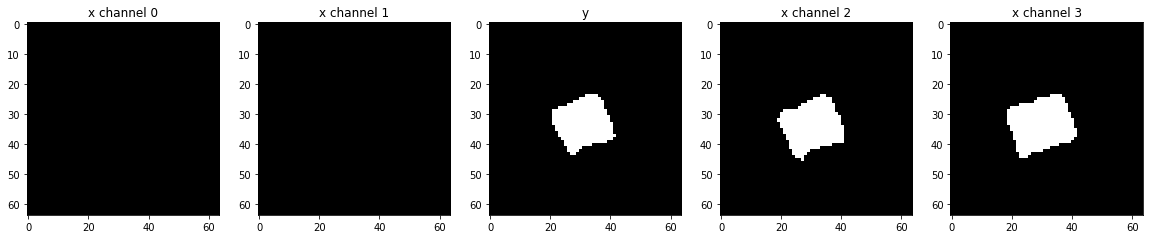

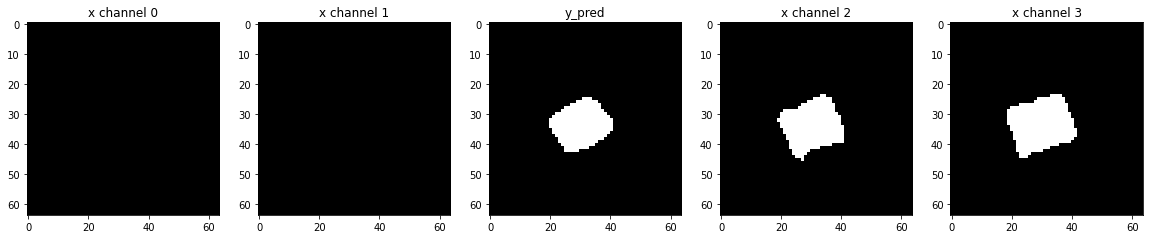

Loss: 0.020336143672466278


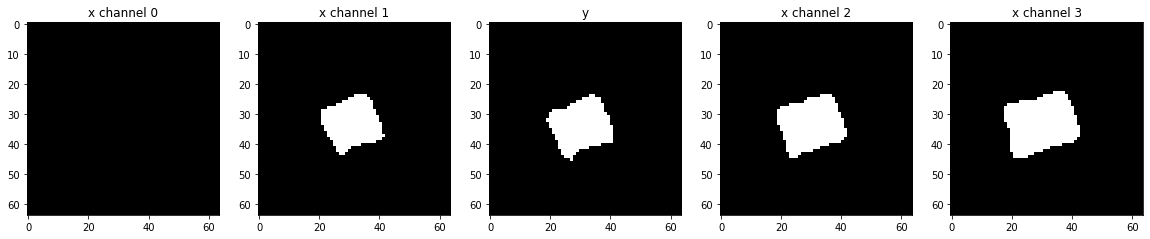

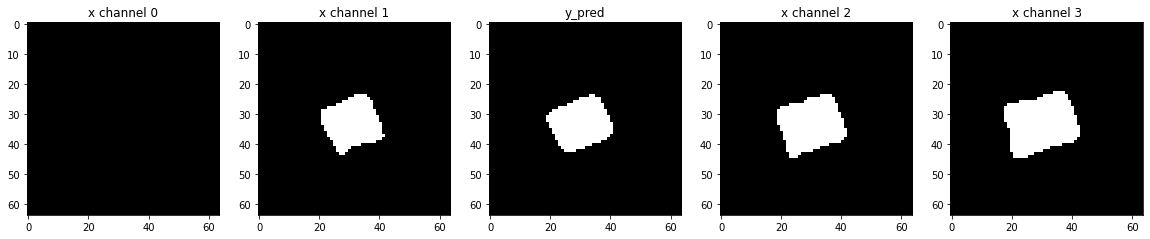

Loss: 0.013637794181704521


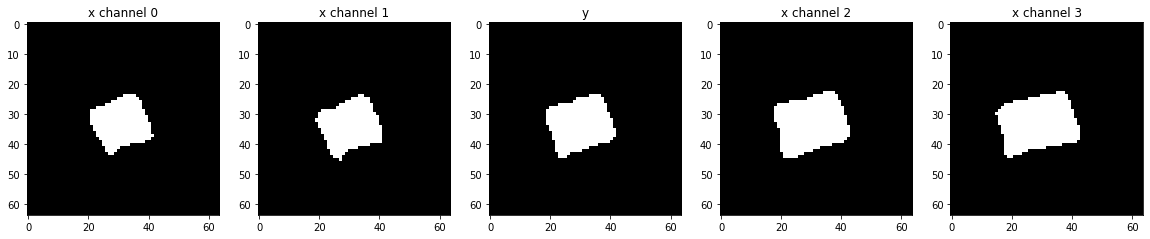

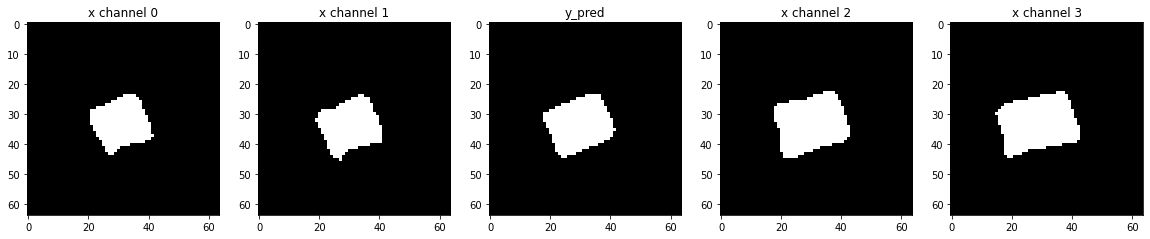

Loss: 0.016125861555337906


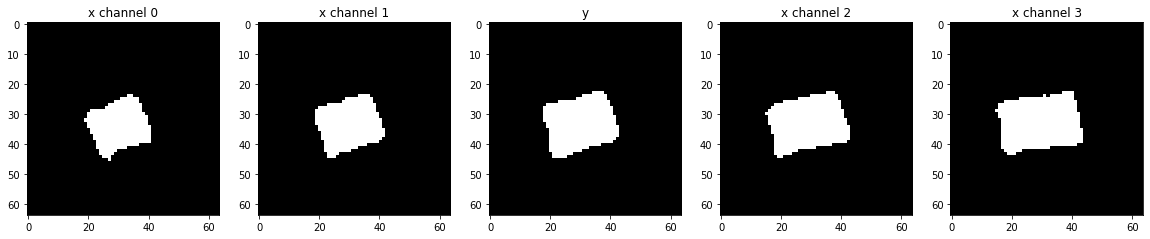

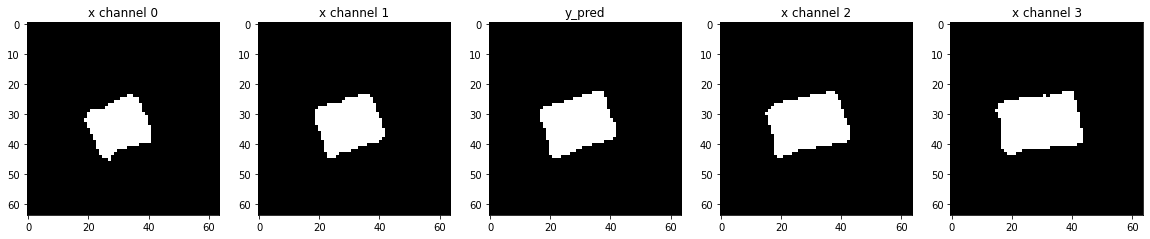

Loss: 0.011590990237891674


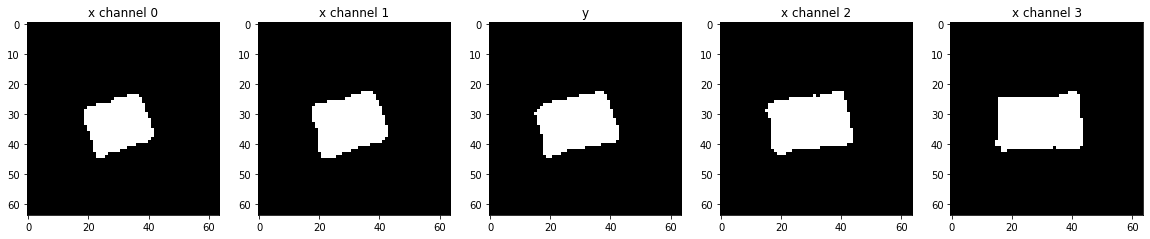

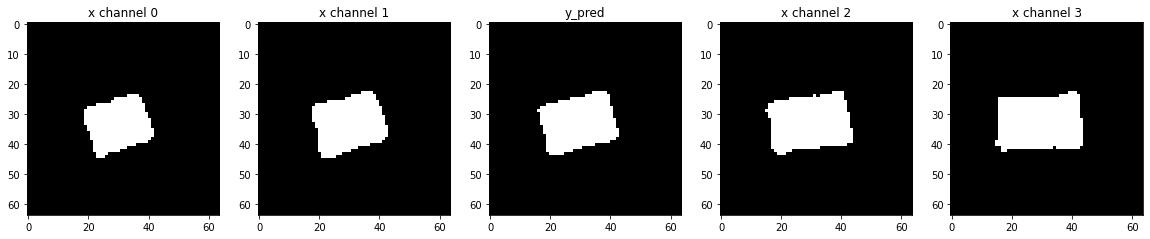

Loss: 0.013847604393959045


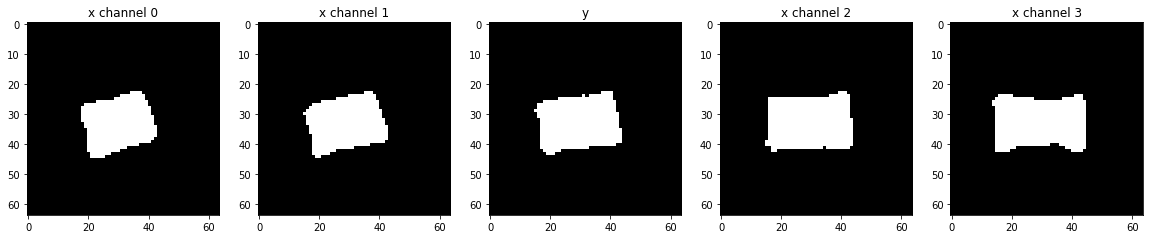

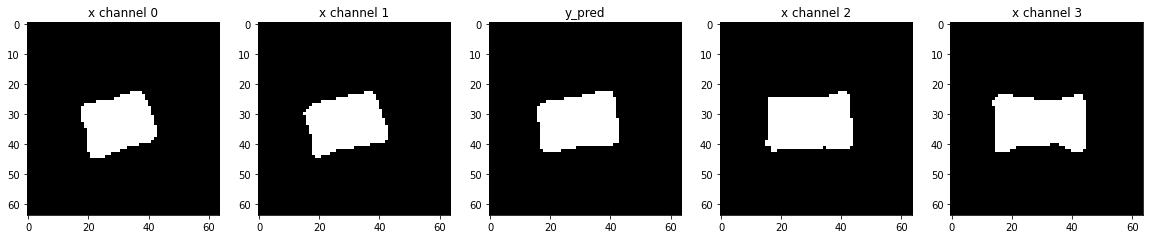

Loss: 0.014434024691581726


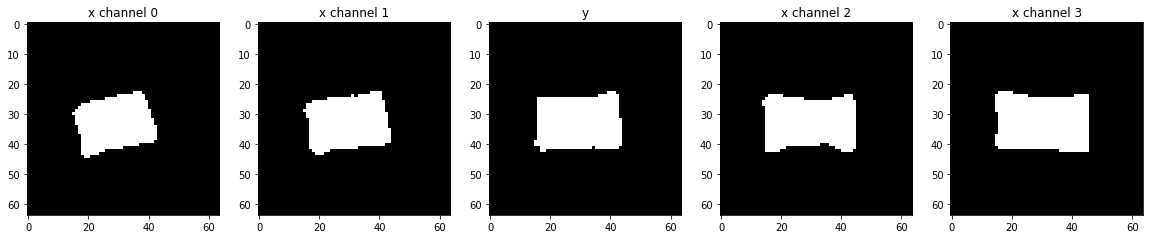

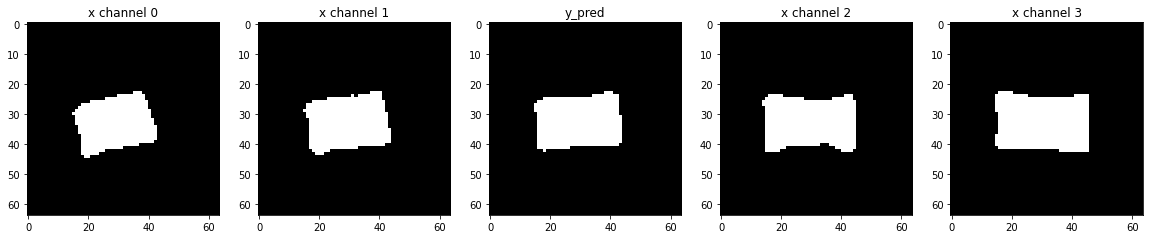

Loss: 0.0205454733222723


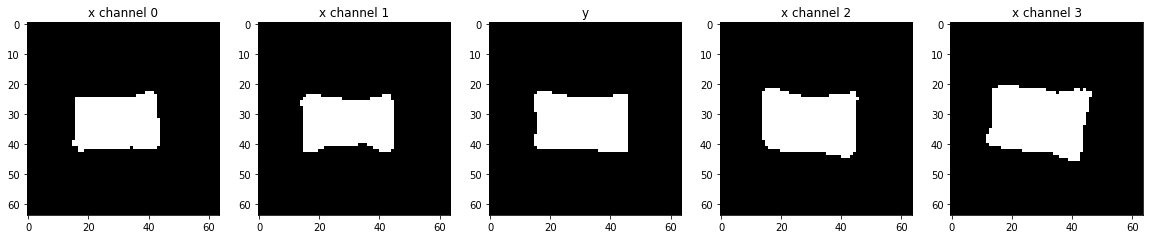

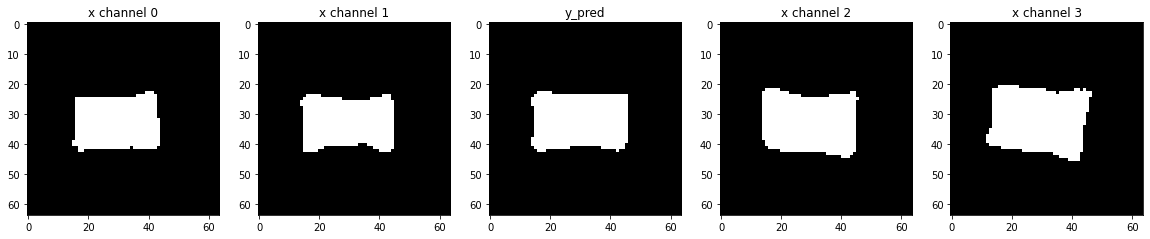

Loss: 0.027872785925865173


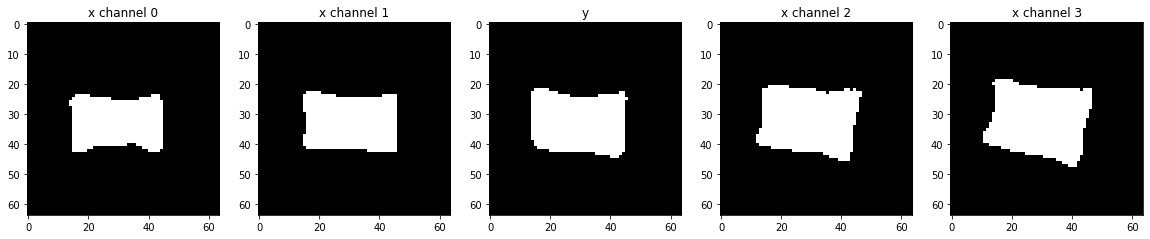

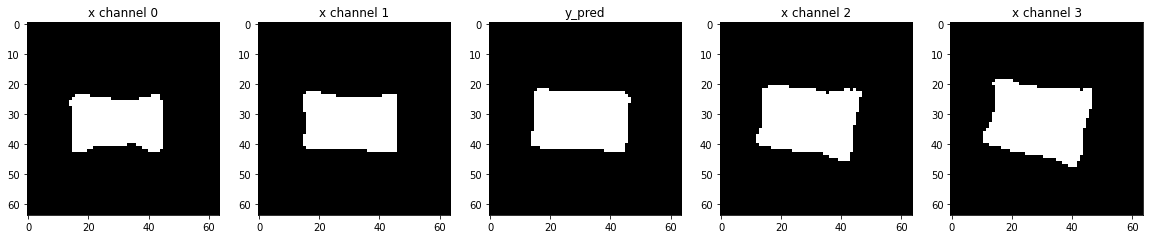

Loss: 0.024248145520687103


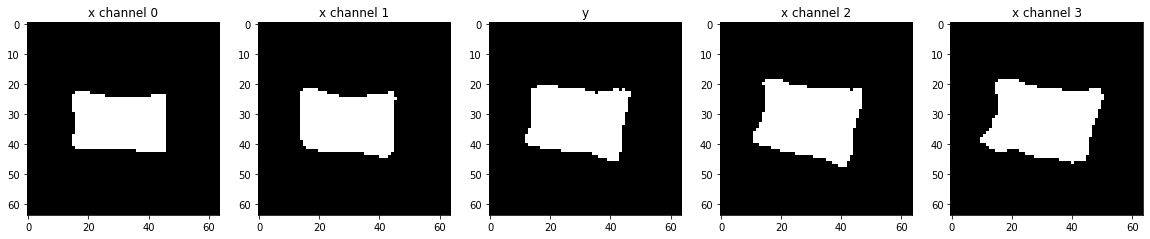

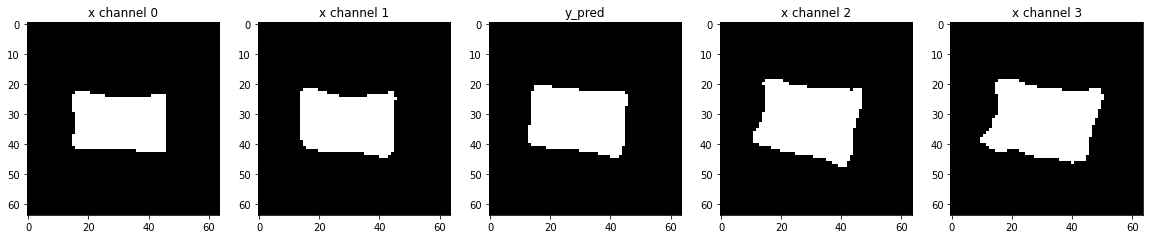

Loss: 0.03881125897169113


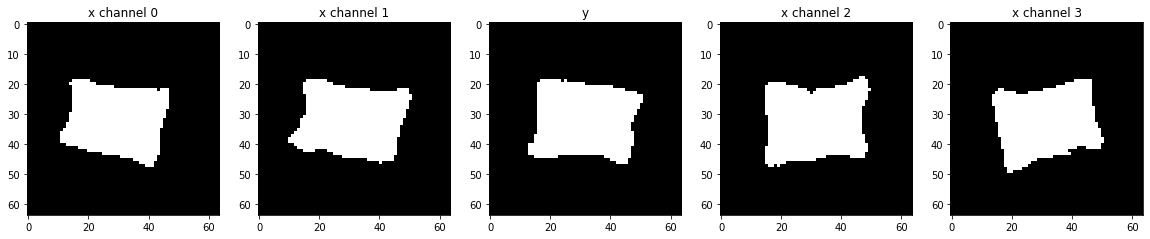

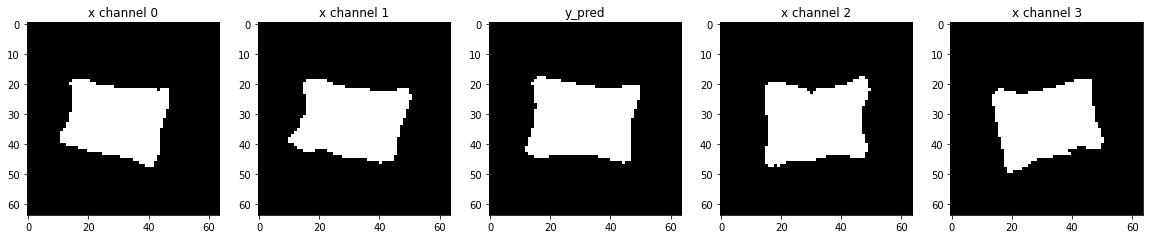

Loss: 0.09760545194149017


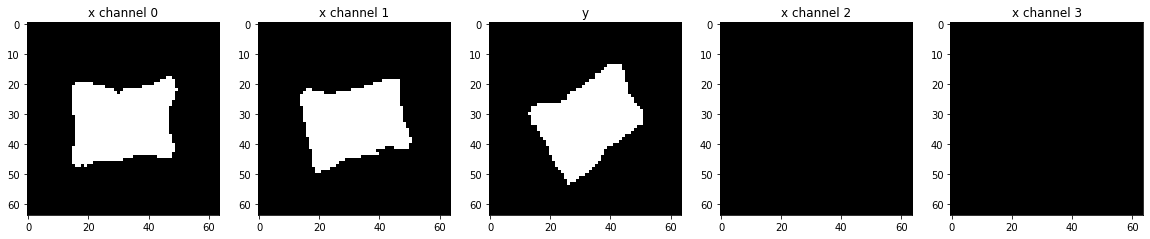

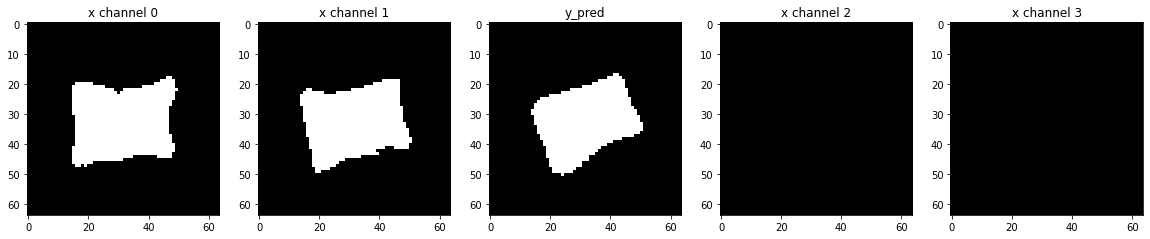

Loss: 0.04915788024663925


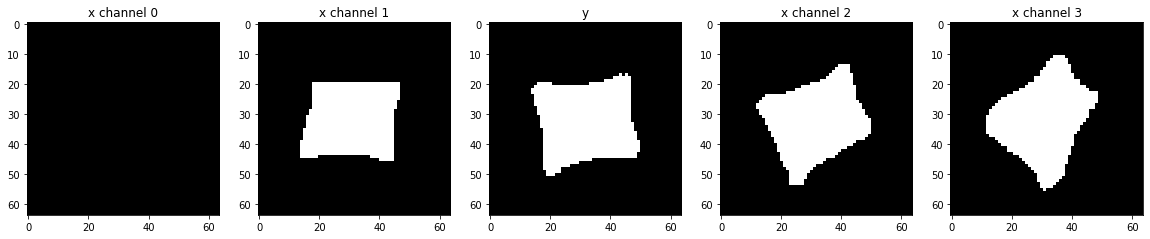

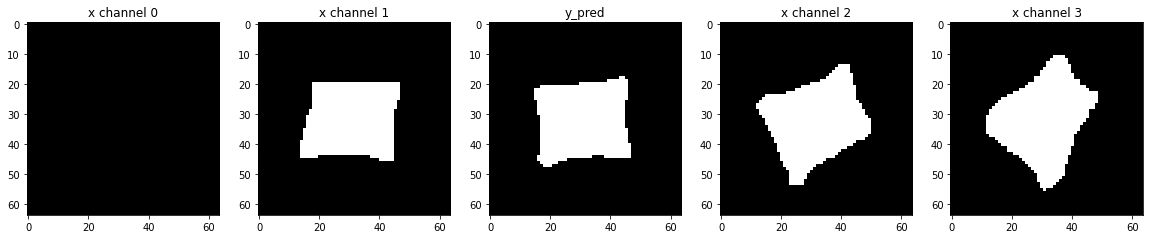

Loss: 0.07310545444488525


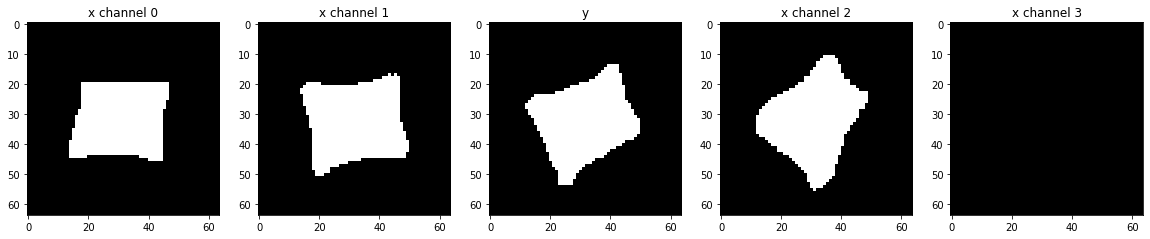

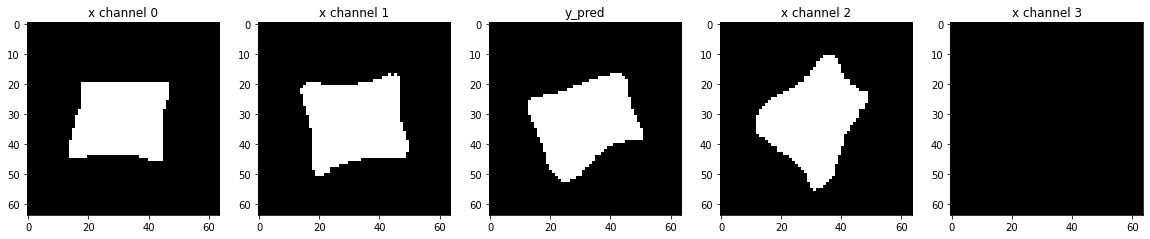

Loss: 0.12224487960338593


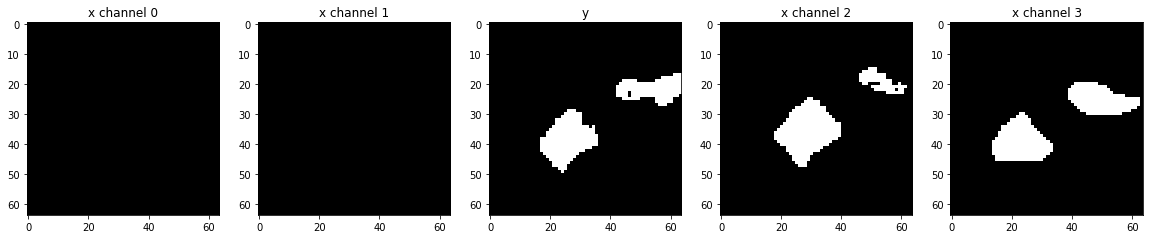

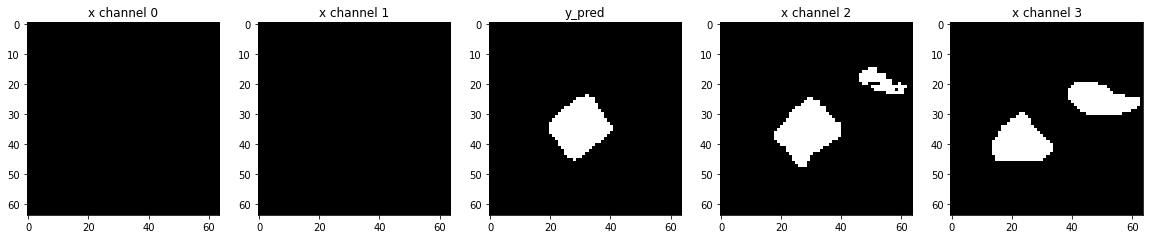

Loss: 0.05658850073814392


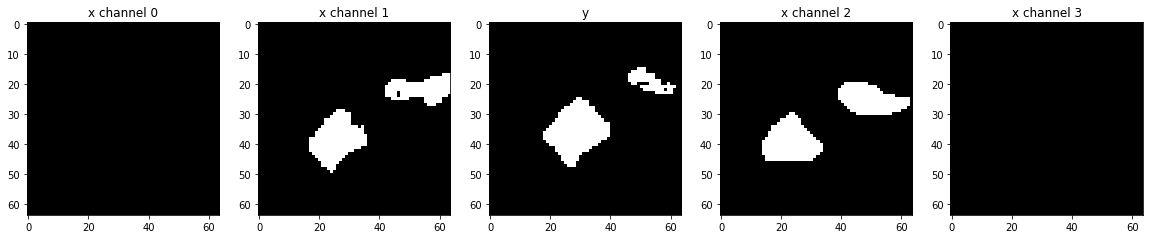

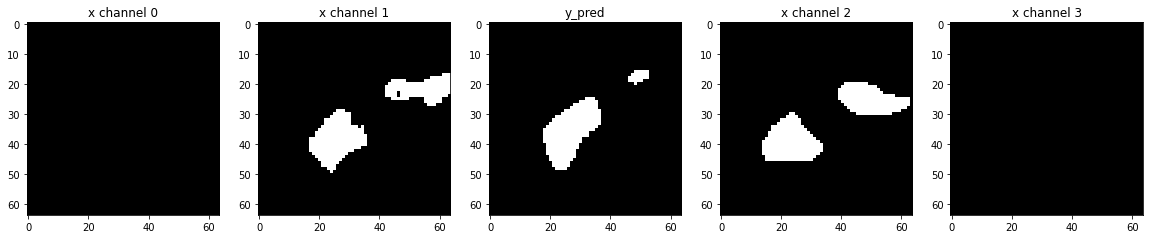

Loss: 0.030298538506031036


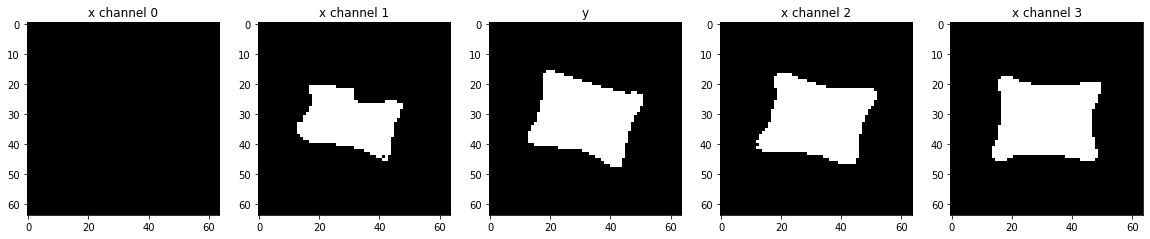

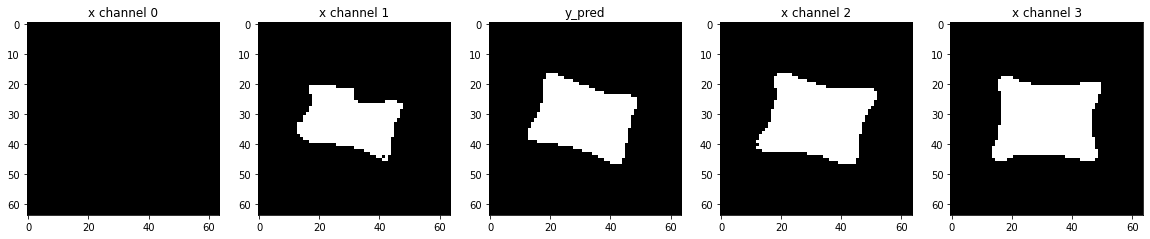

Loss: 0.02696504443883896


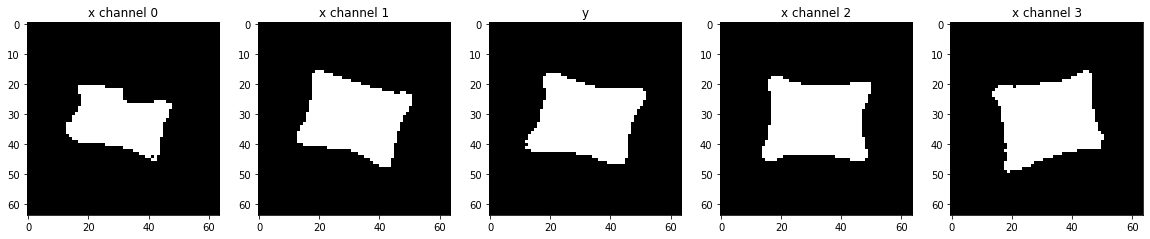

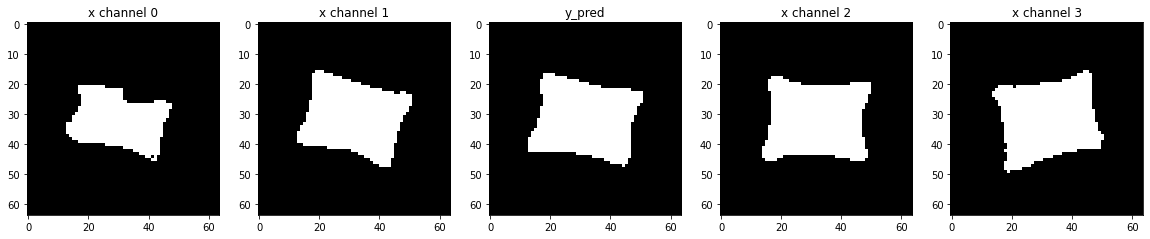

Loss: 0.028324436396360397


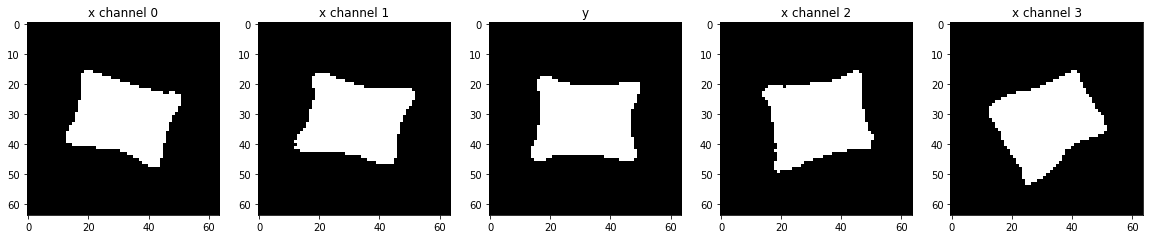

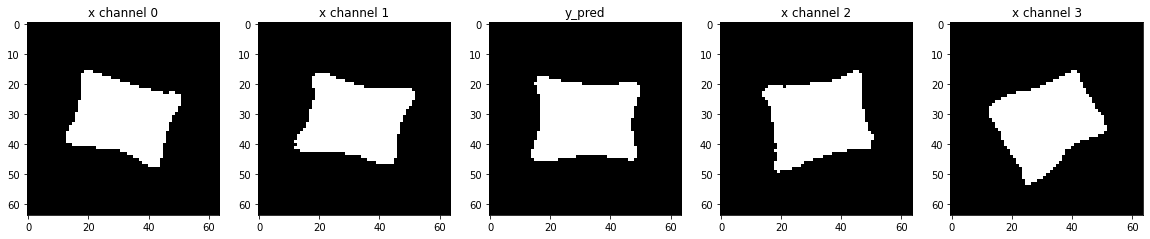

Loss: 0.04402793571352959


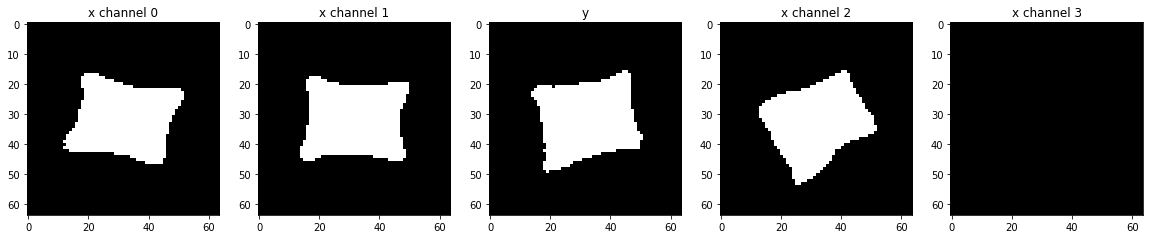

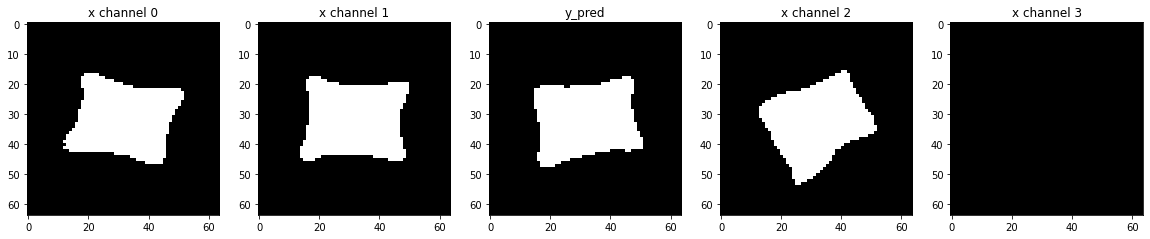

Loss: 0.038684673607349396


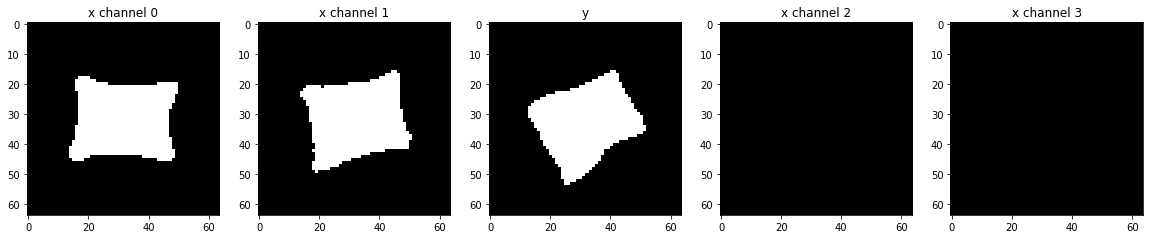

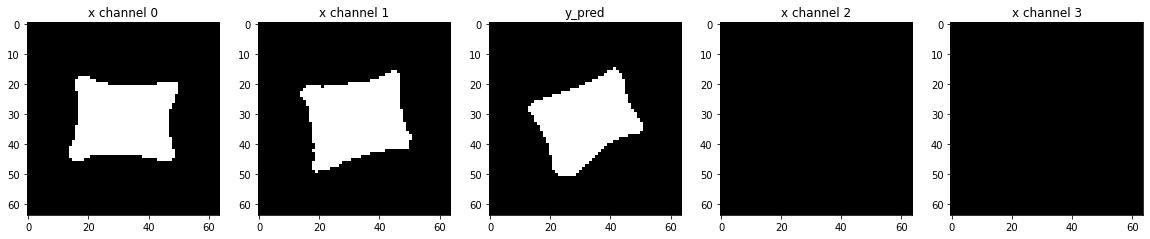

Loss: 0.027535542845726013


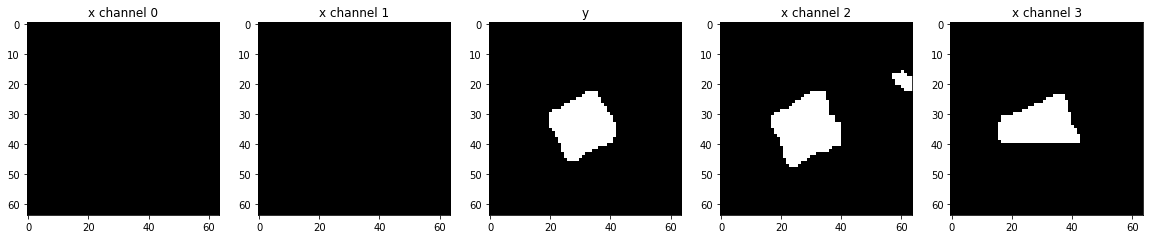

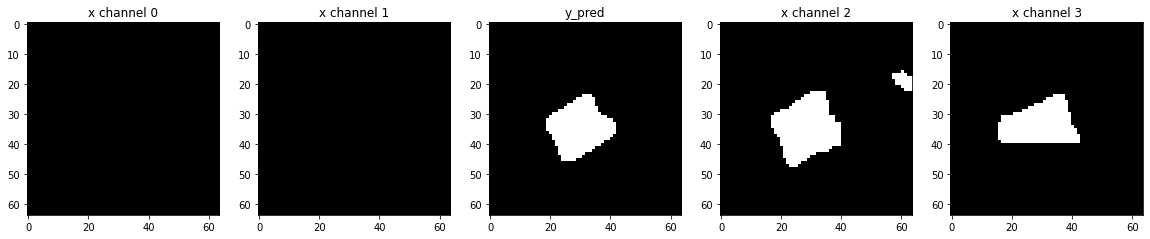

Loss: 0.04450749605894089


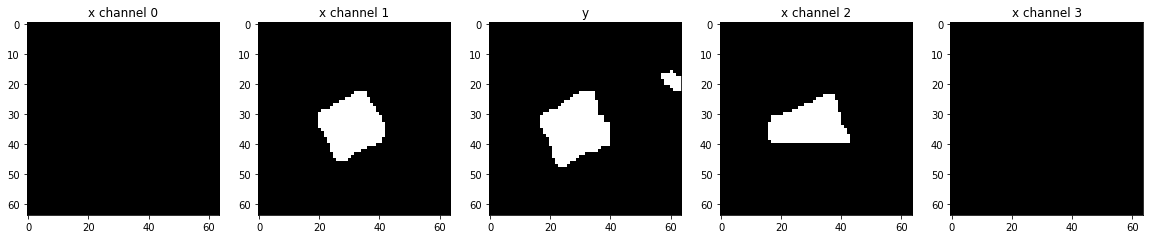

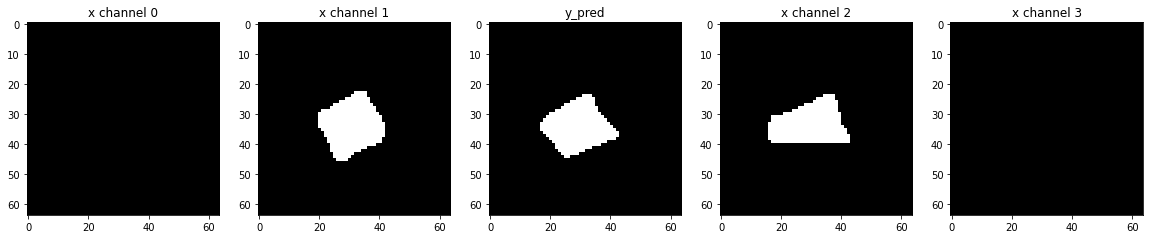

Loss: 0.020805492997169495


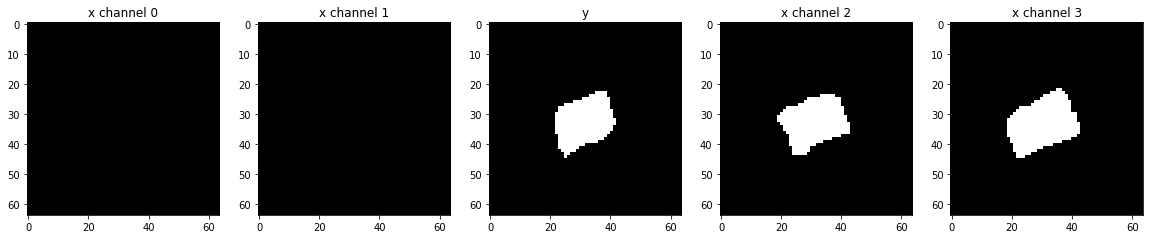

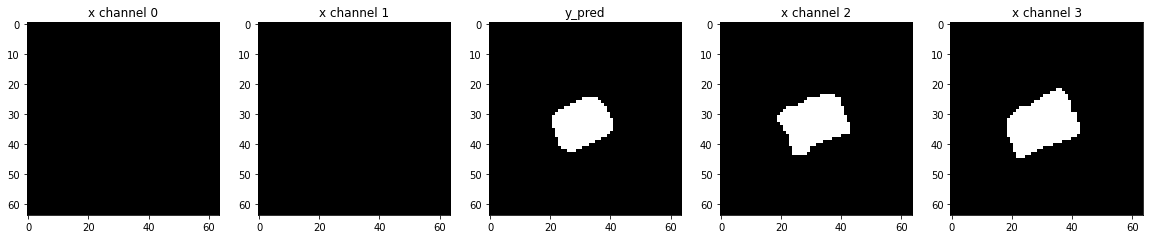

Loss: 0.01935606449842453


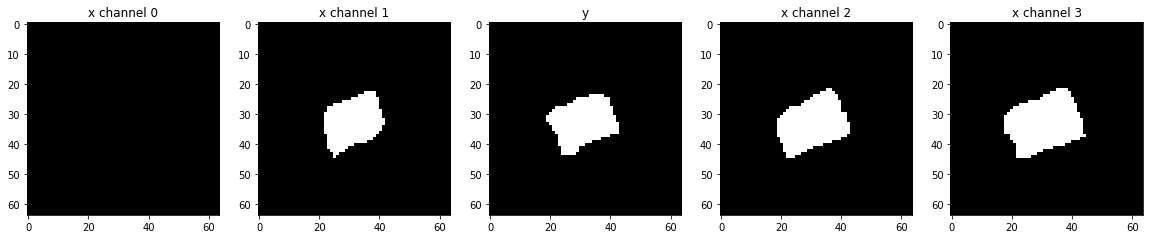

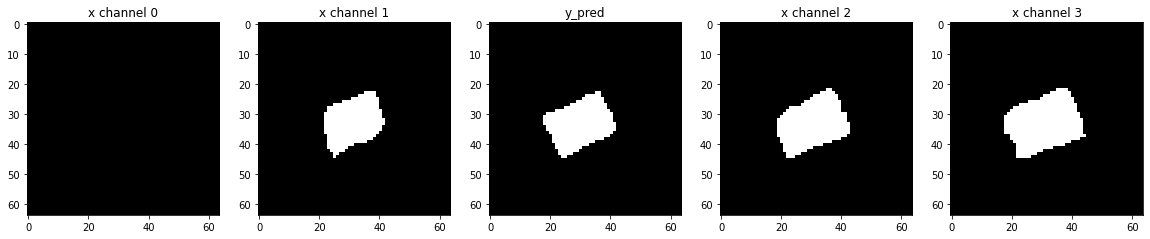

Loss: 0.01957780495285988


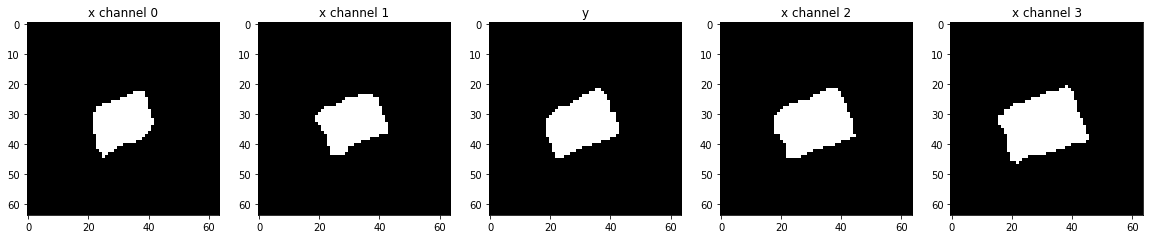

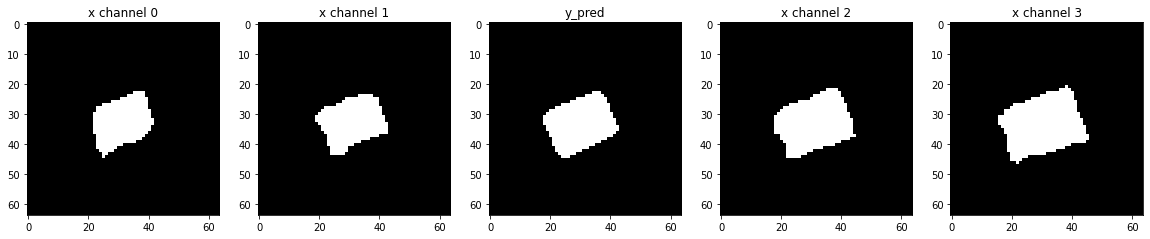

Loss: 0.021377909928560257


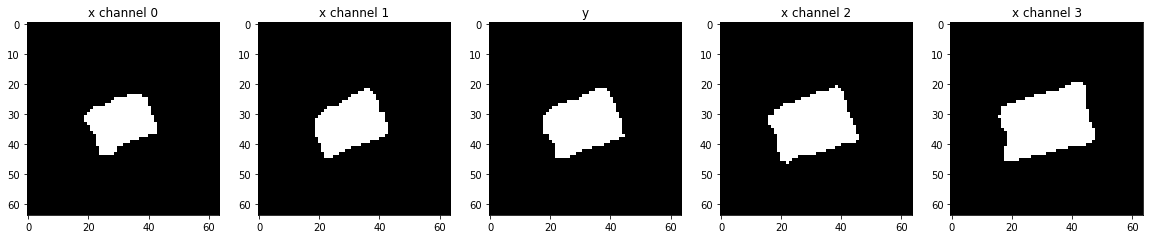

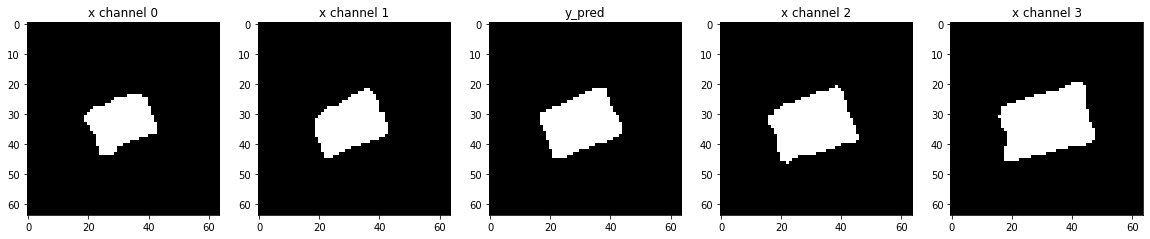

Loss: 0.016668541356921196


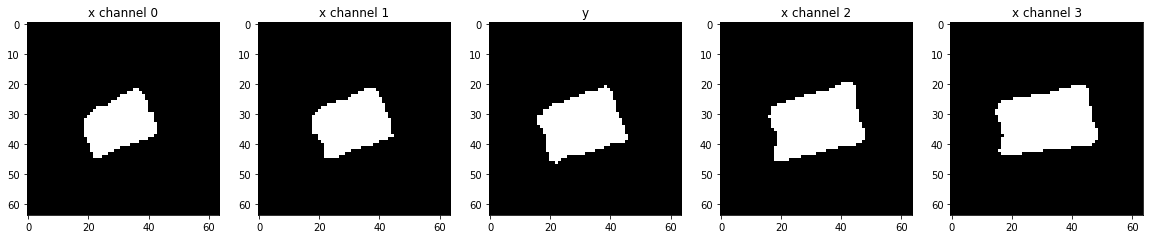

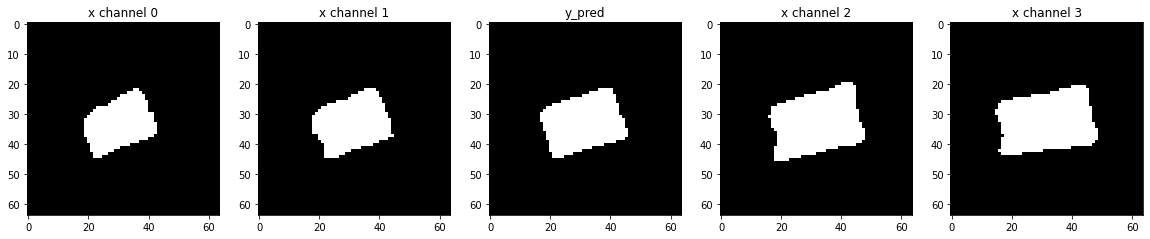

Loss: 0.025827202945947647


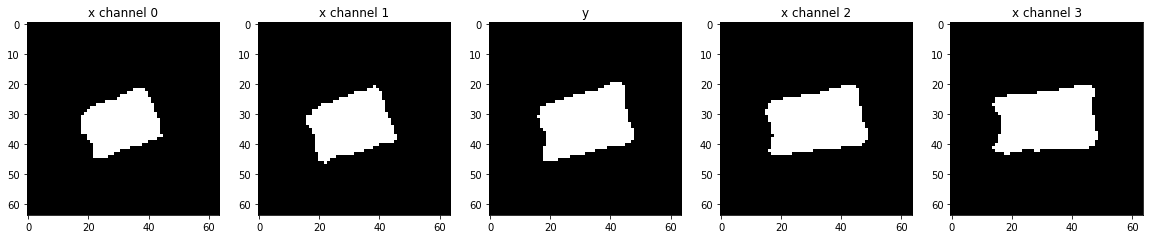

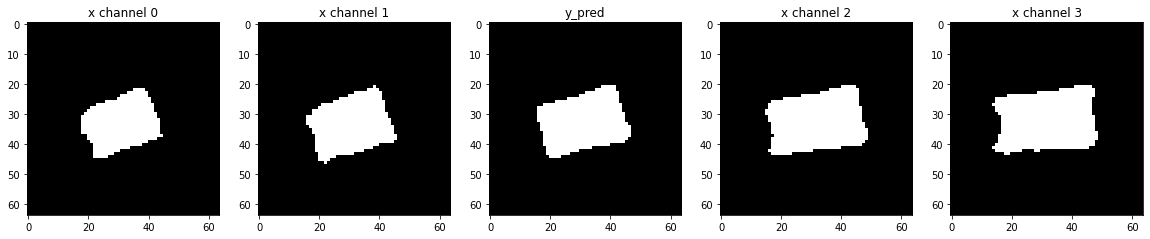

Loss: 0.021032243967056274


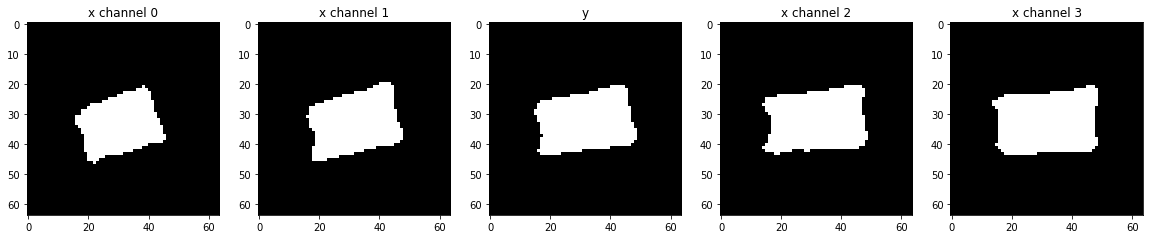

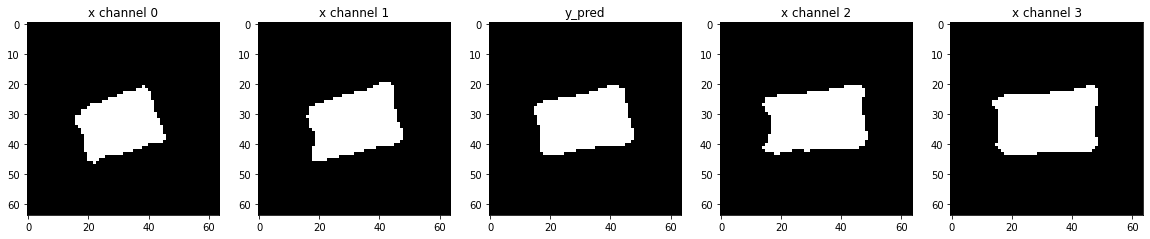

Loss: 0.024285845458507538


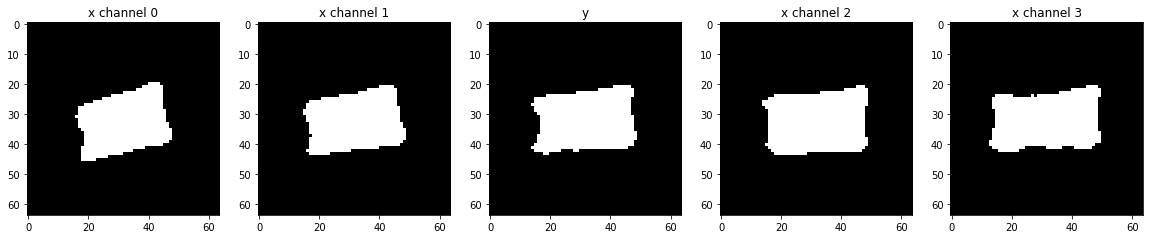

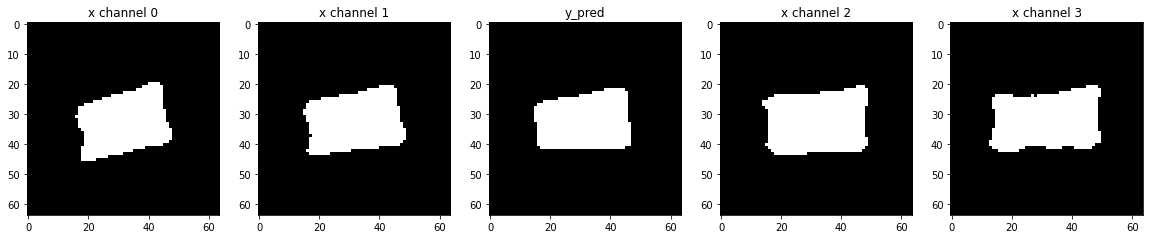

Loss: 0.034157782793045044


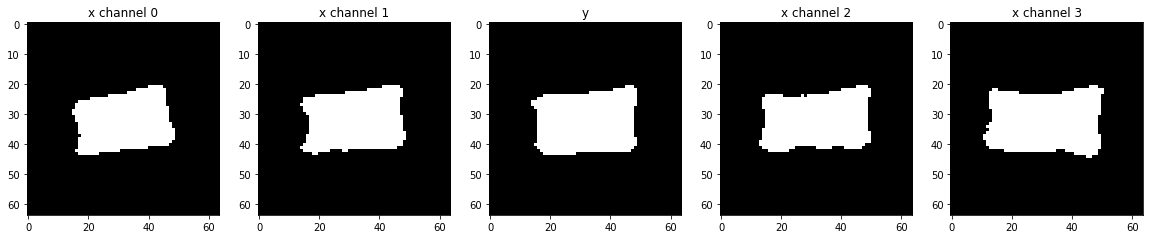

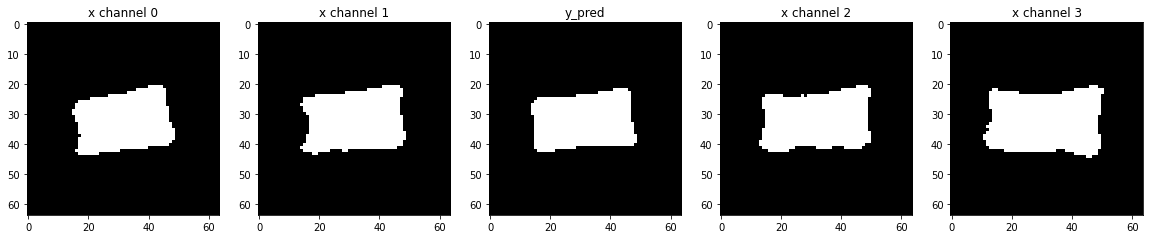

Loss: 0.03526396304368973


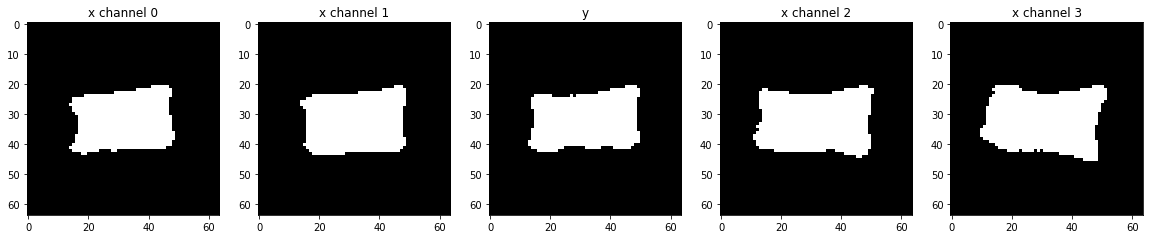

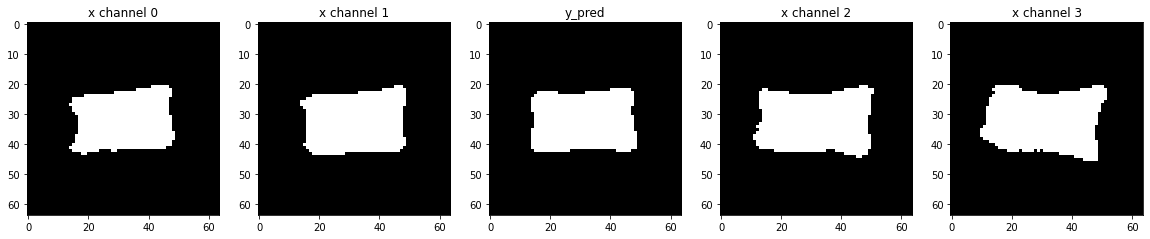

Loss: 0.0483129546046257


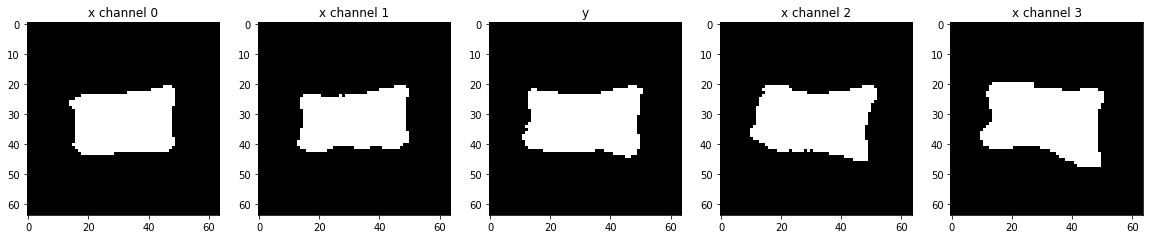

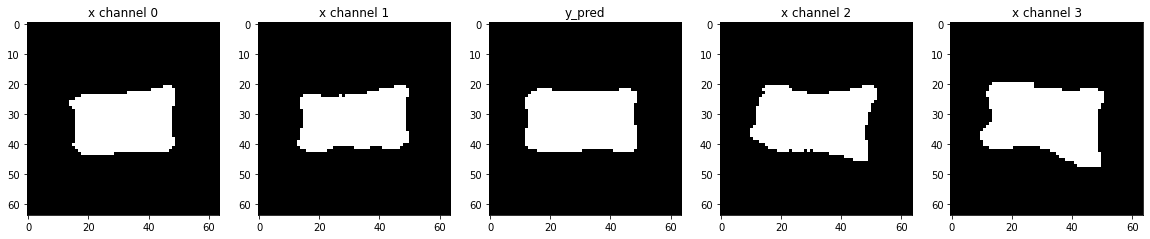

Loss: 0.033249225467443466


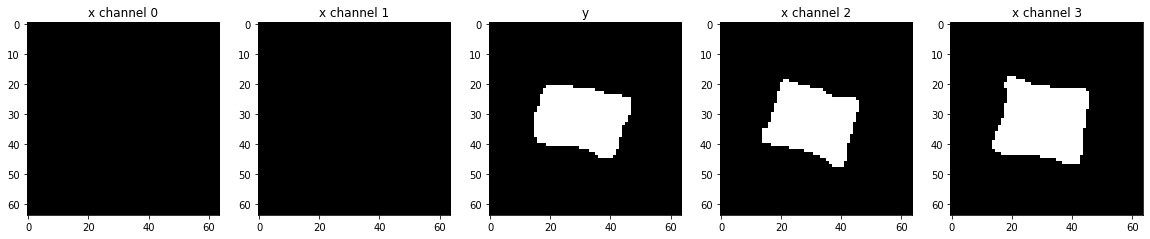

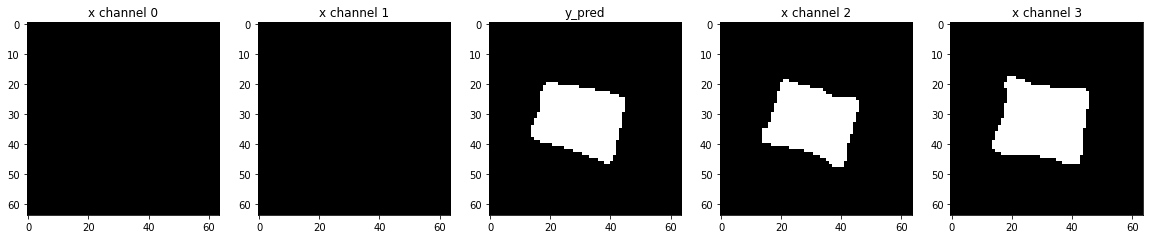

Loss: 0.03112485073506832


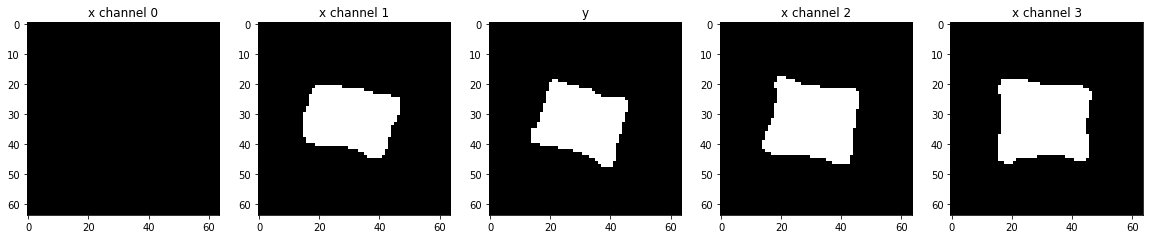

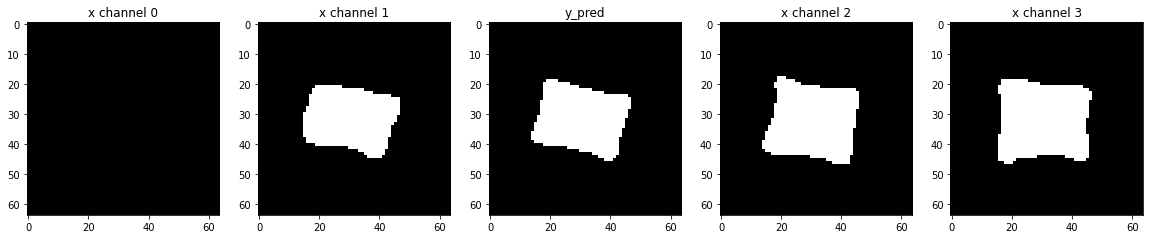

Loss: 0.026859208941459656


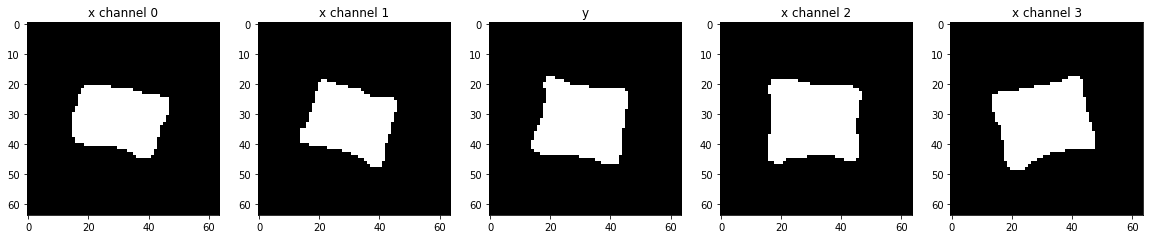

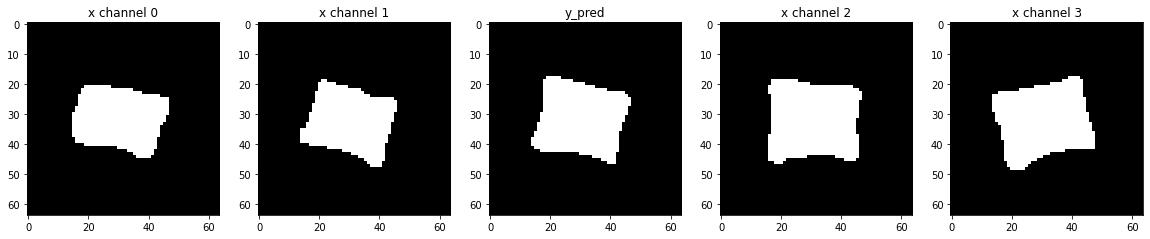

Loss: 0.026814788579940796


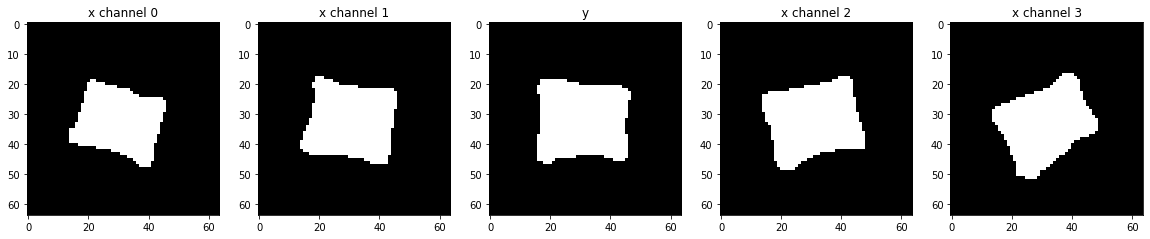

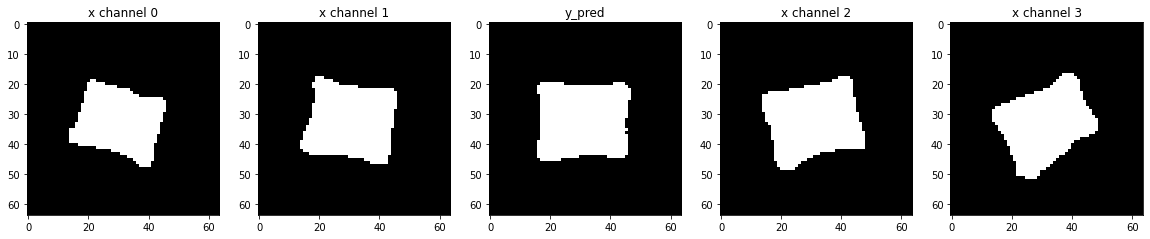

Loss: 0.026182735338807106


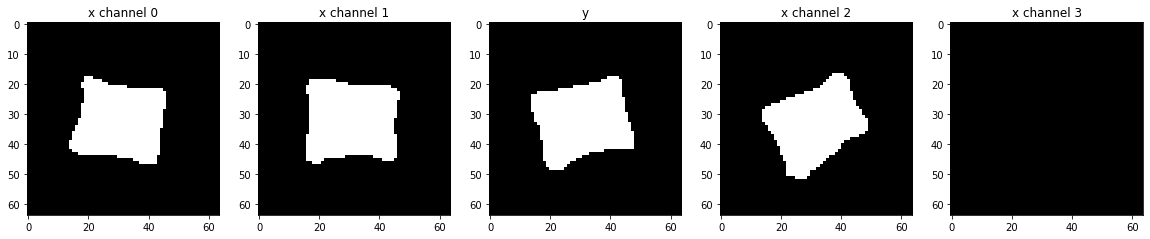

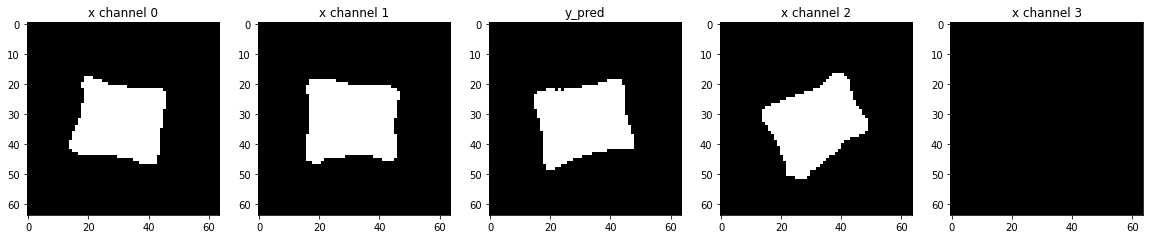

Loss: 0.0418982170522213


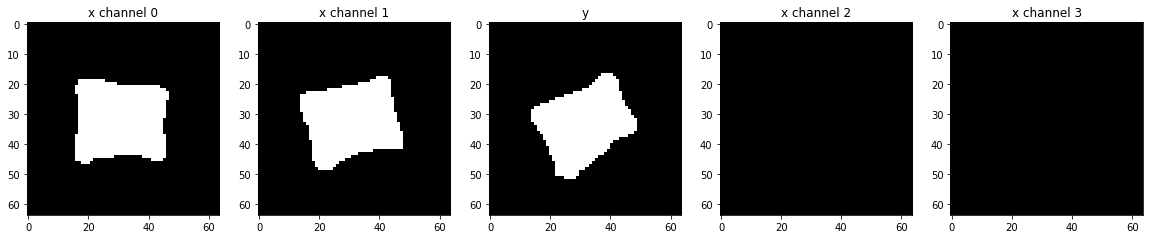

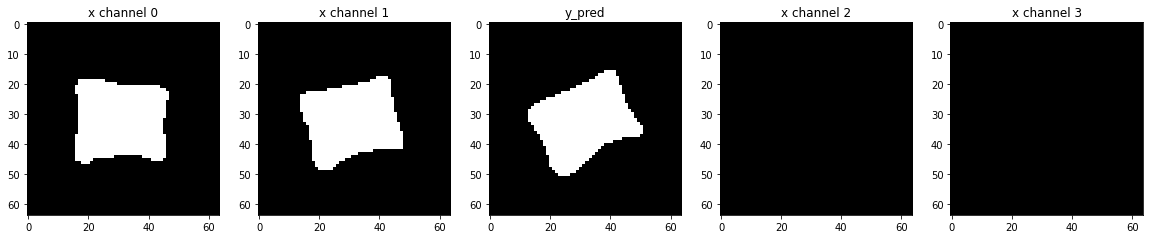

Loss: 0.03468451648950577


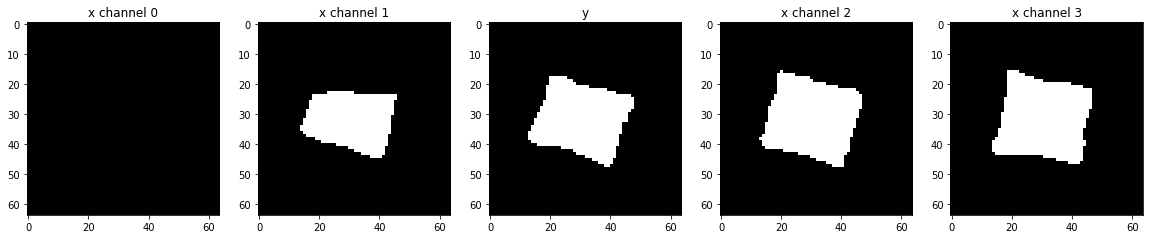

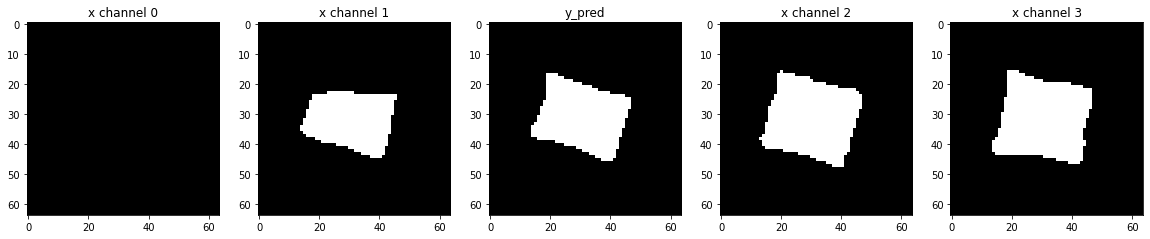

Loss: 0.024120837450027466


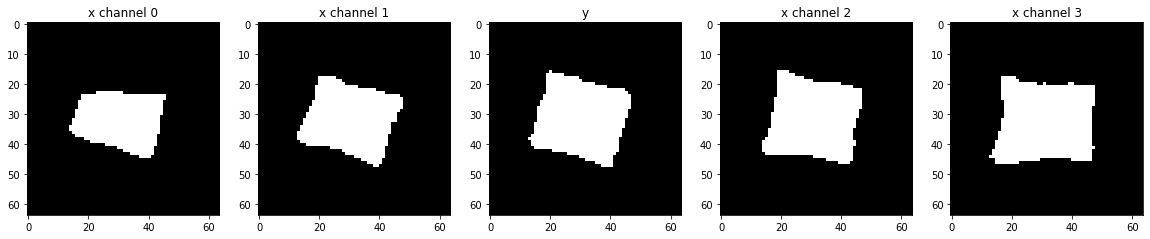

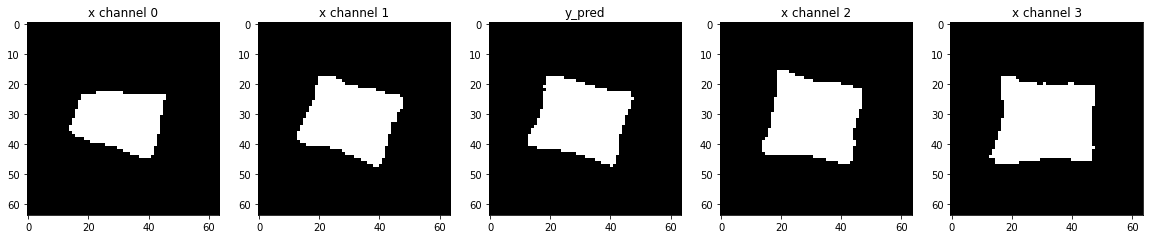

Loss: 0.028130996972322464


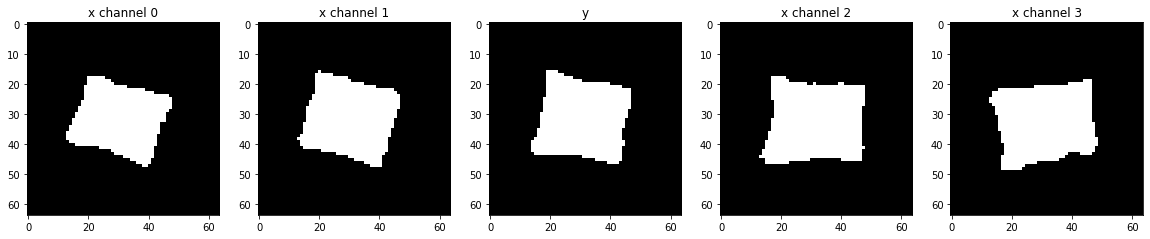

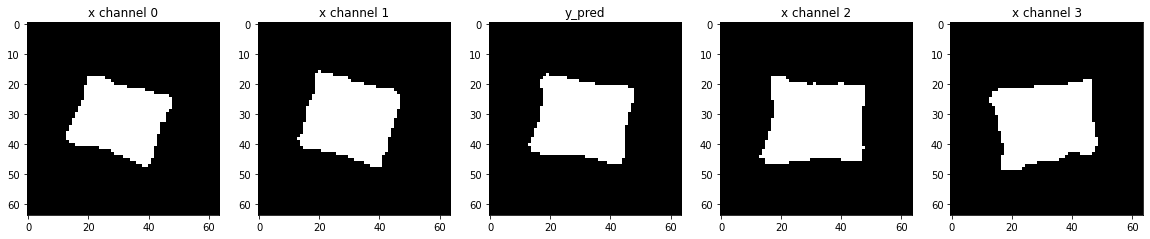

Loss: 0.033085897564888


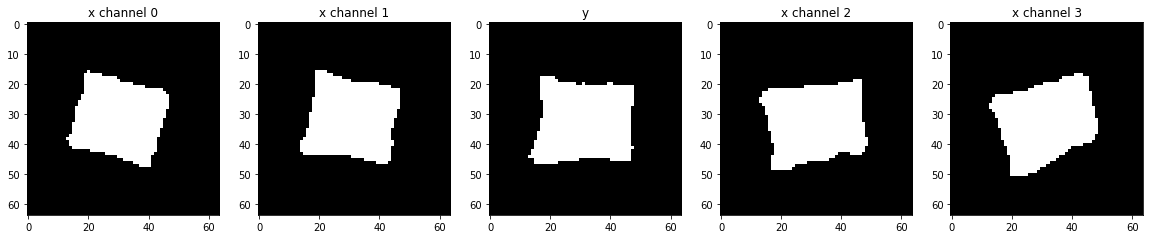

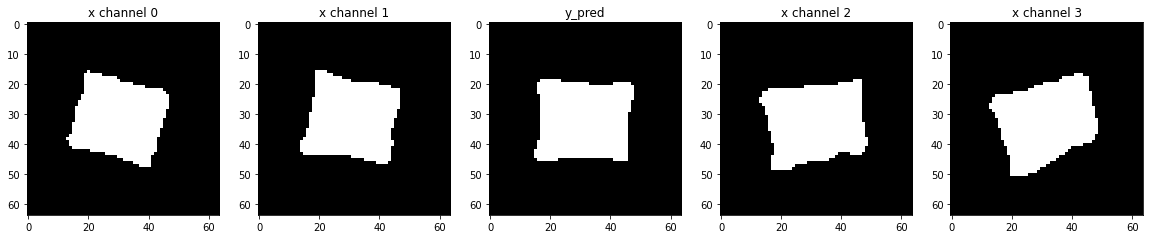

Loss: 0.052250515669584274


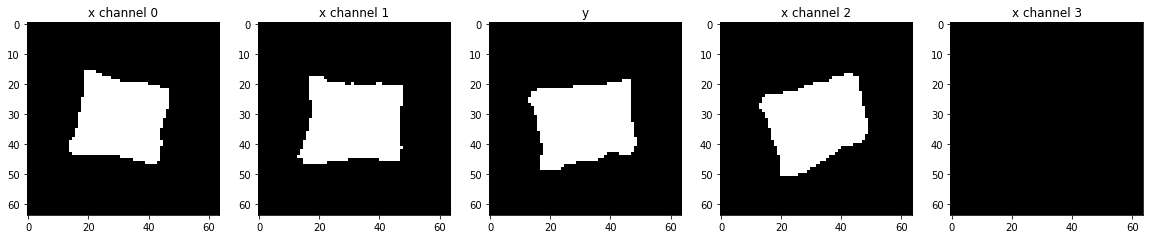

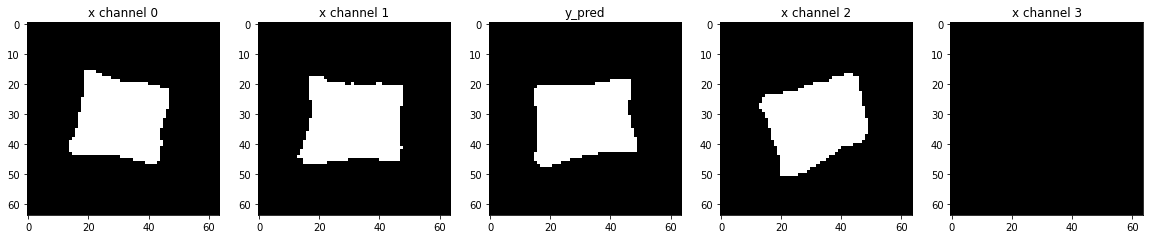

Loss: 0.05698908865451813


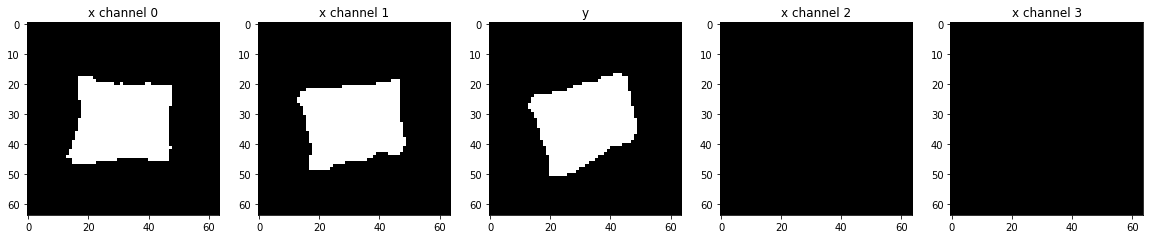

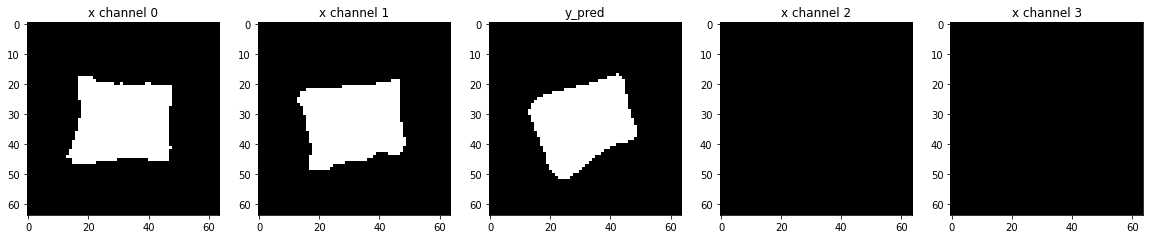

Loss: 0.021750375628471375


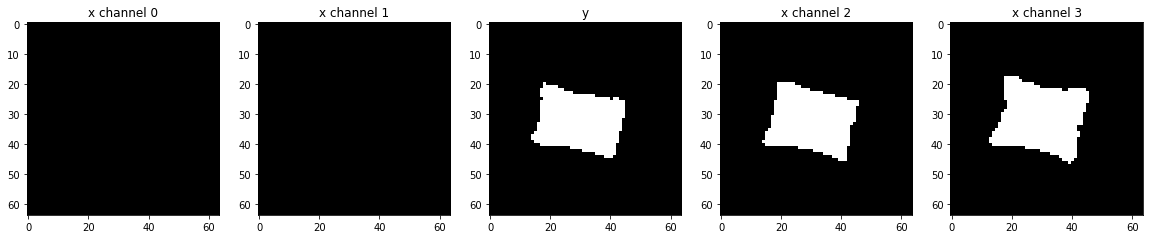

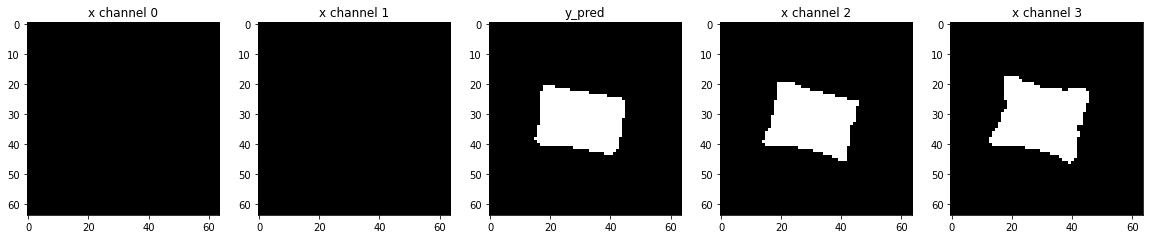

Loss: 0.021254733204841614


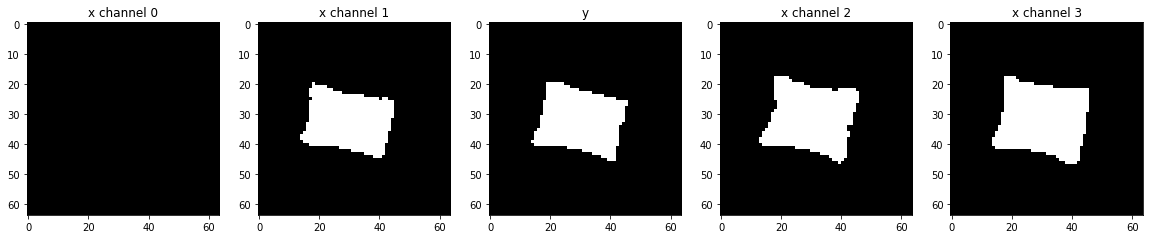

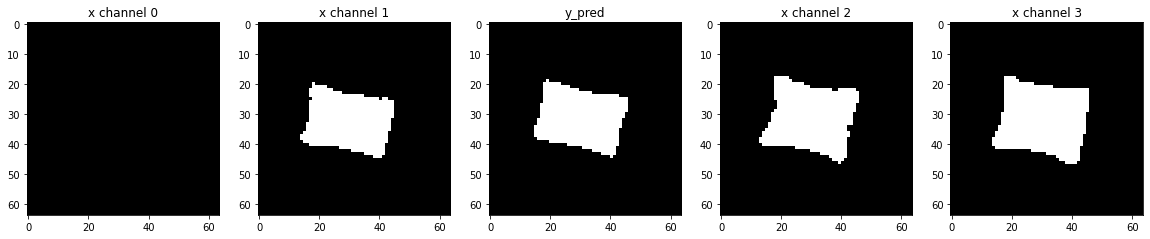

Loss: 0.06410786509513855


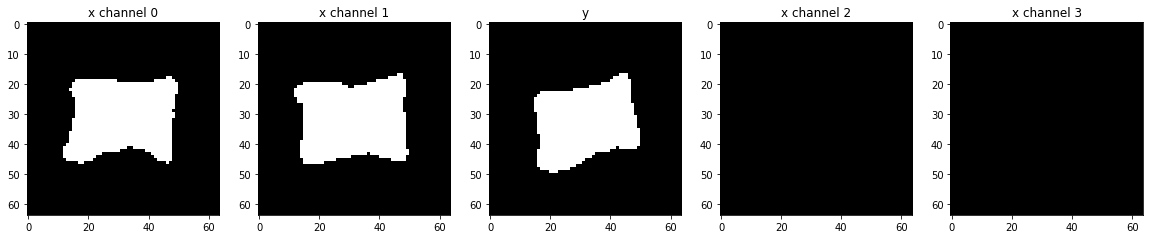

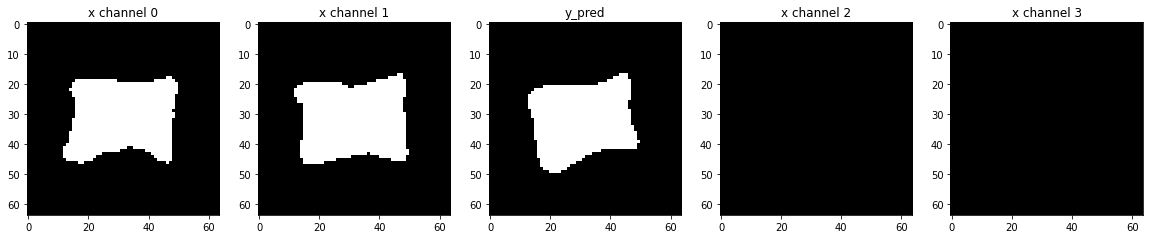

Loss: 0.027901407331228256


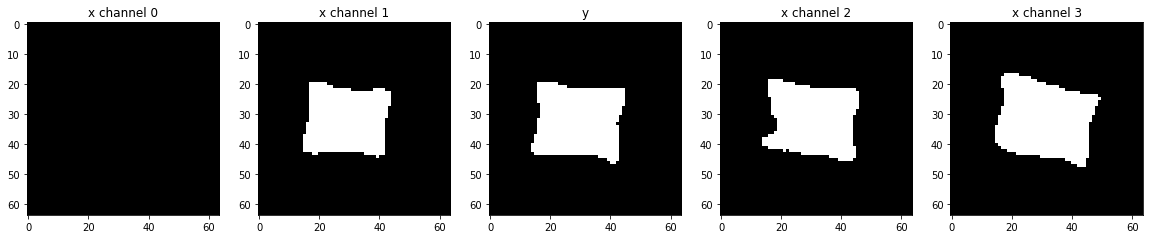

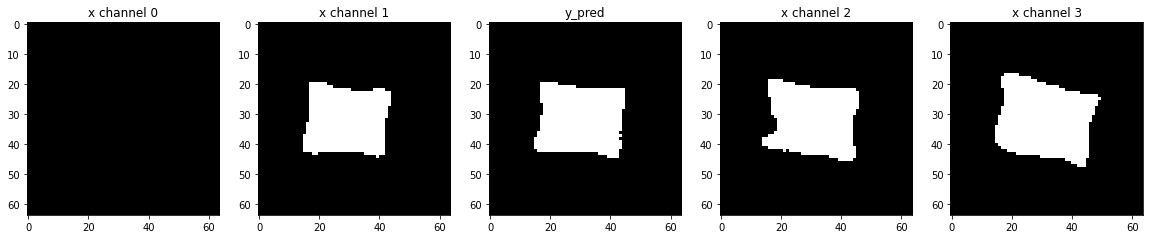

Loss: 0.03532329946756363


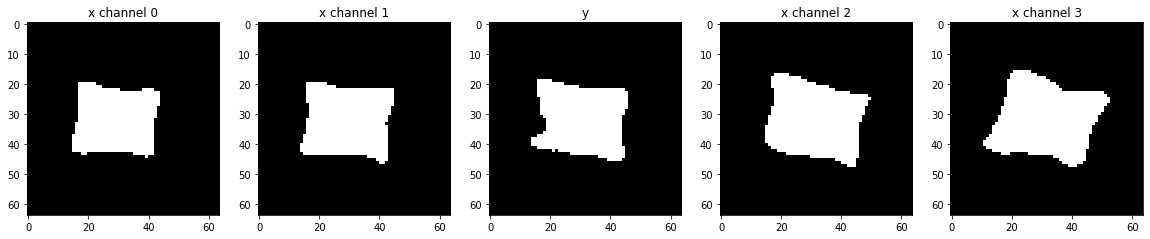

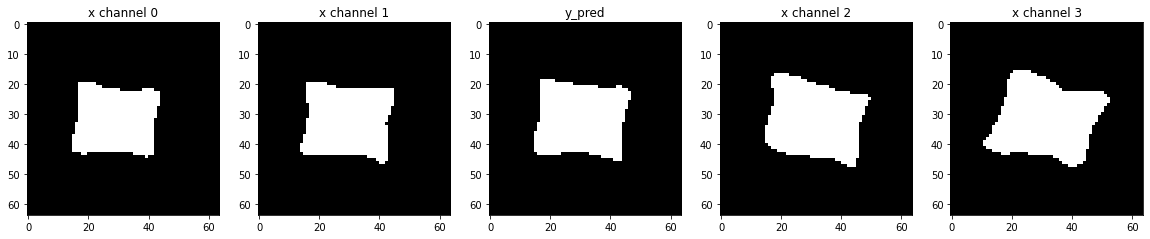

Loss: 0.05897745117545128


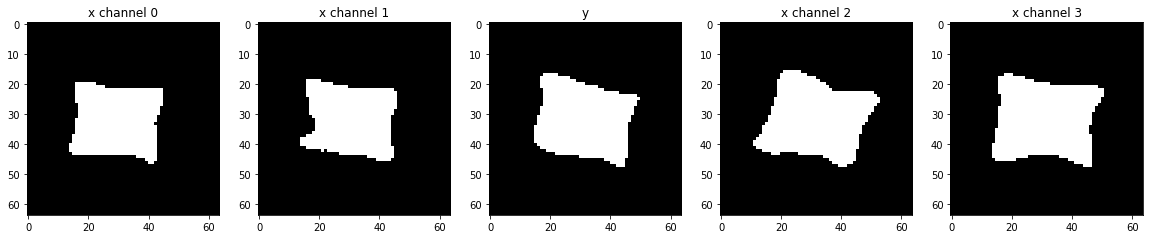

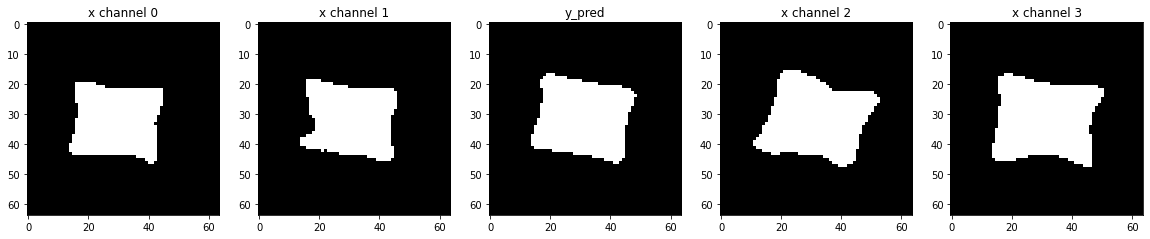

Loss: 0.0544622465968132


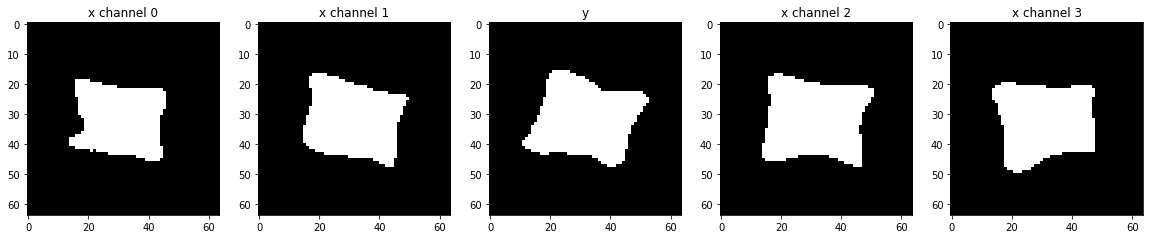

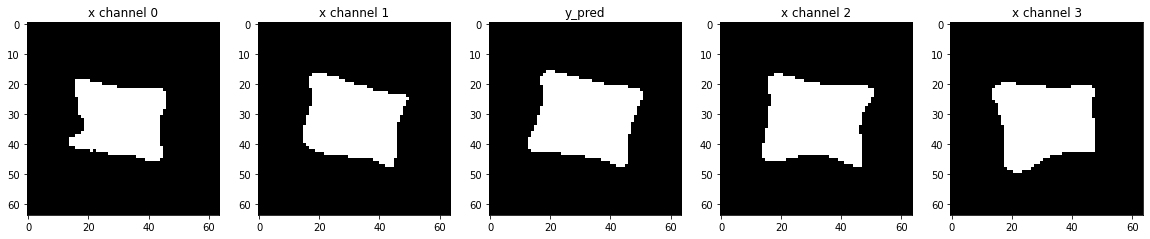

Loss: 0.04371429234743118


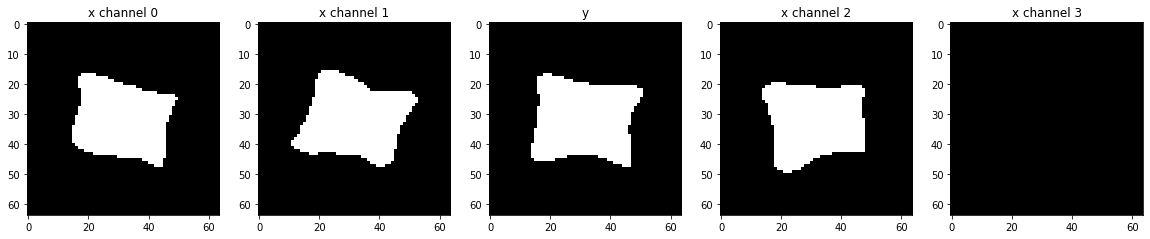

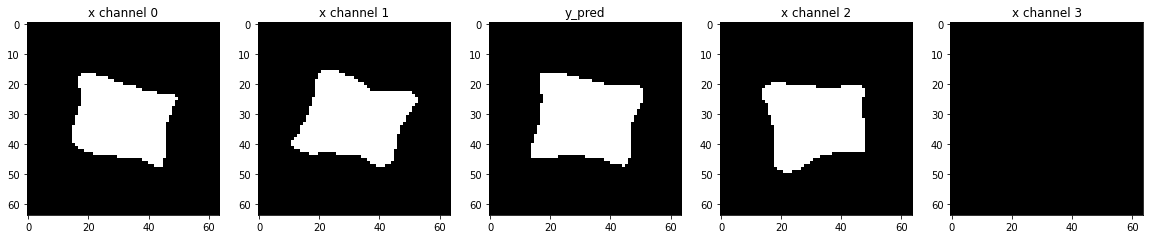

Loss: 0.0512271374464035


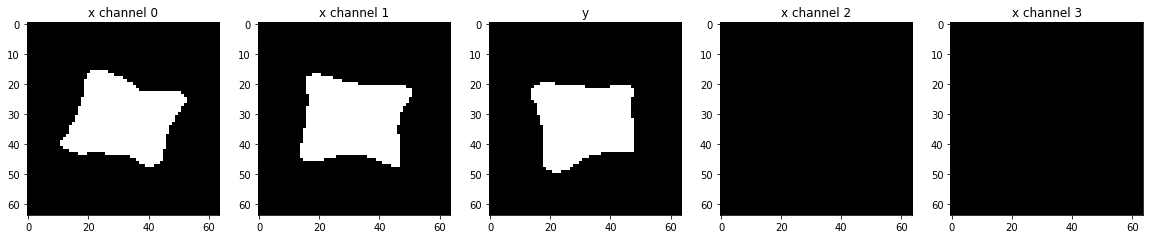

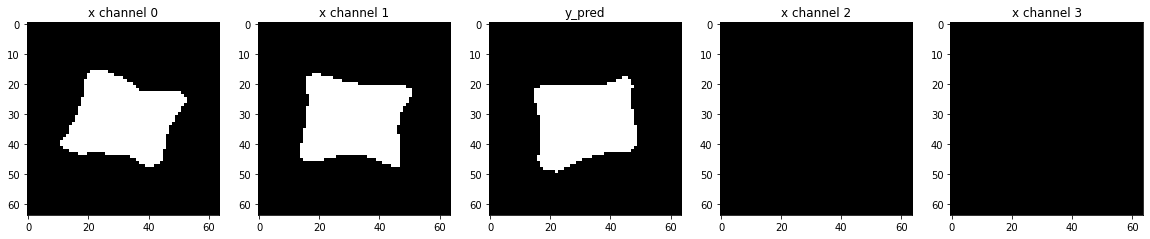

Loss: 0.018373500555753708


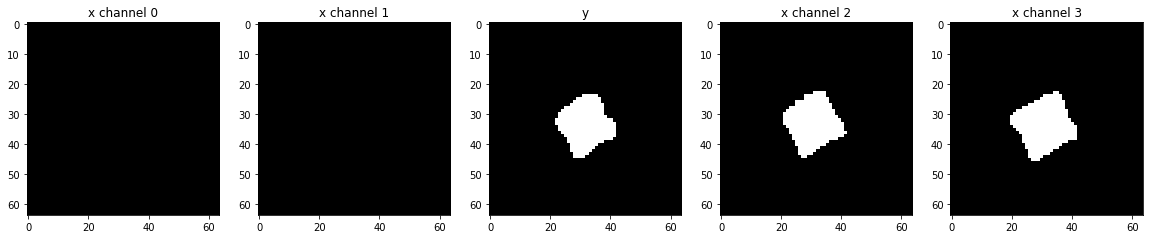

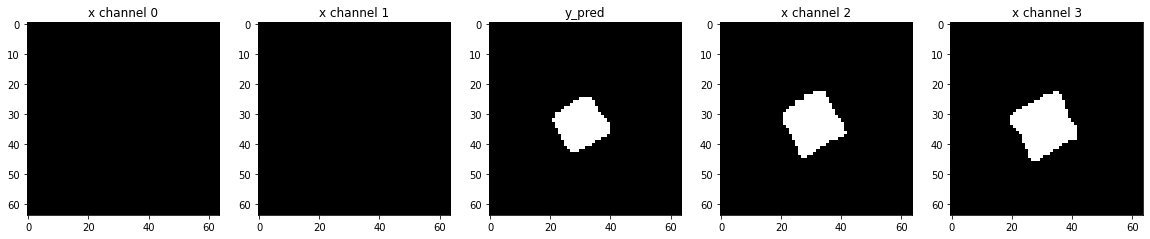

Loss: 0.017375312745571136


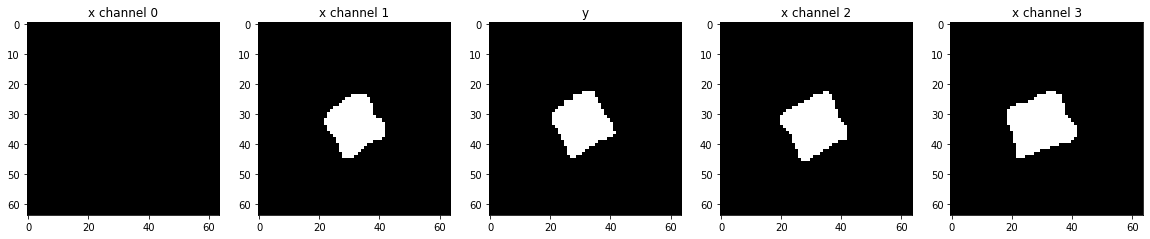

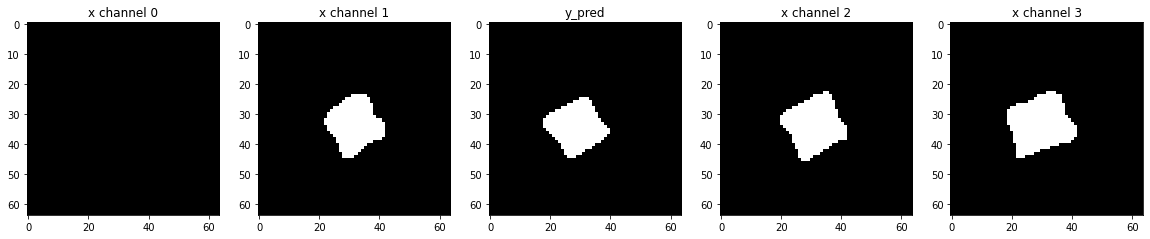

Loss: 0.019301580265164375


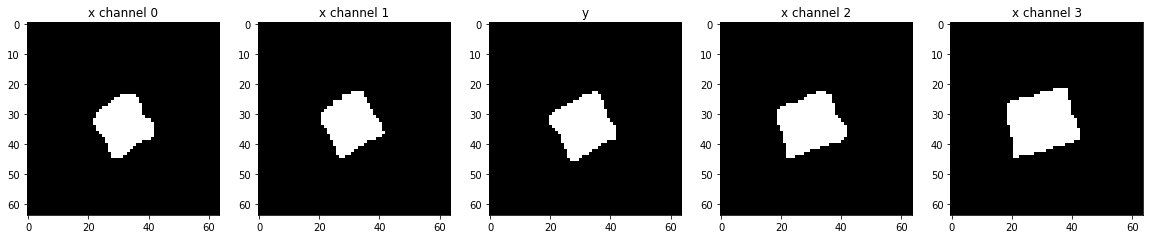

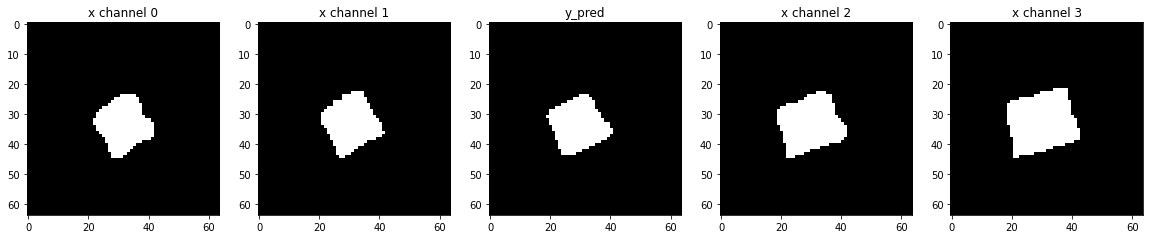

Loss: 0.011699972674250603


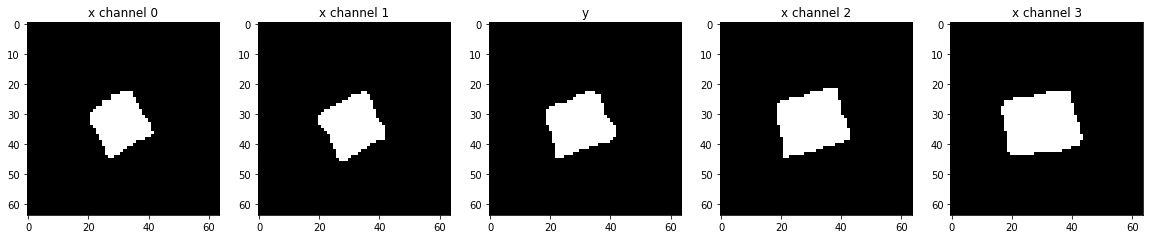

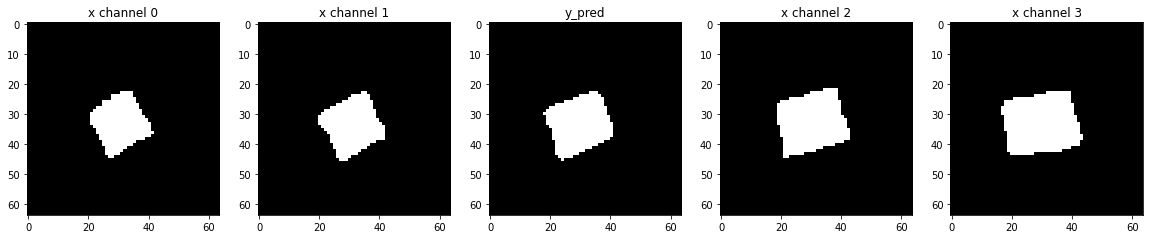

Loss: 0.011851251125335693


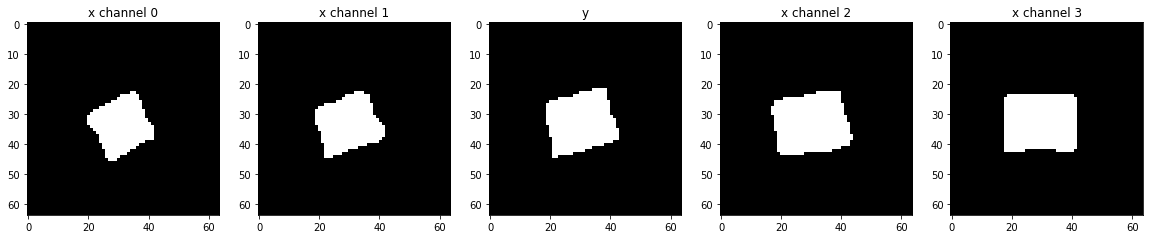

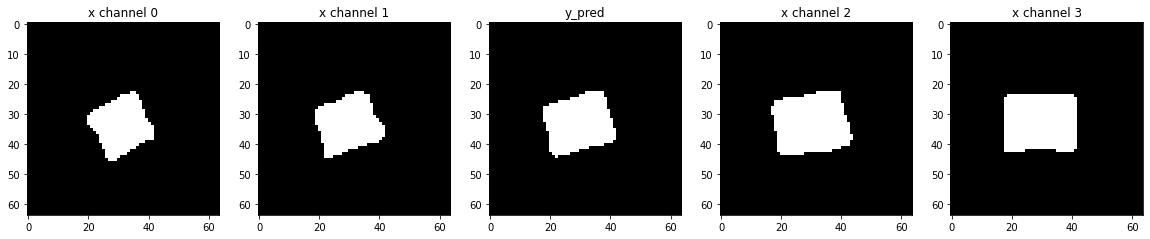

Loss: 0.012590890750288963


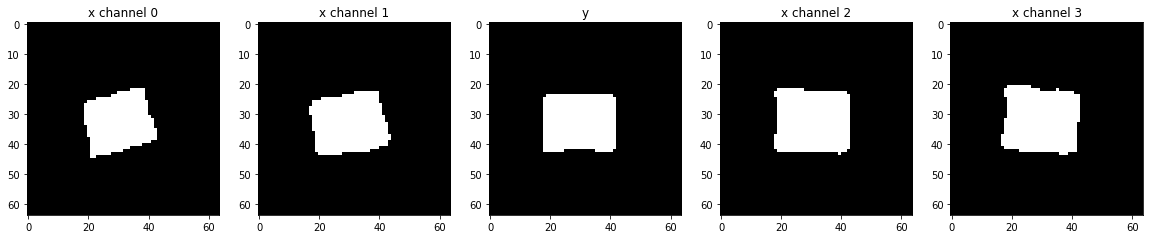

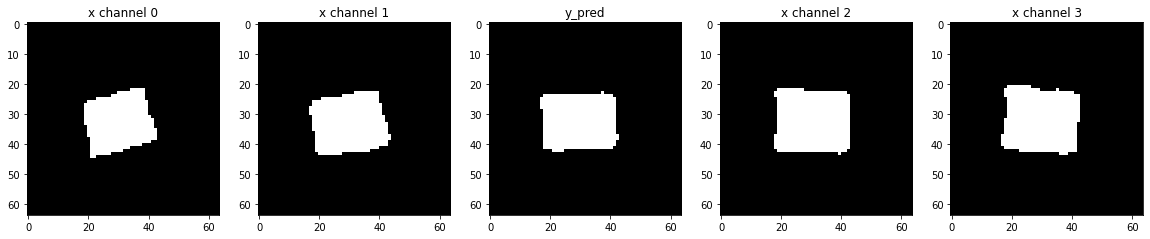

Loss: 0.01674375683069229


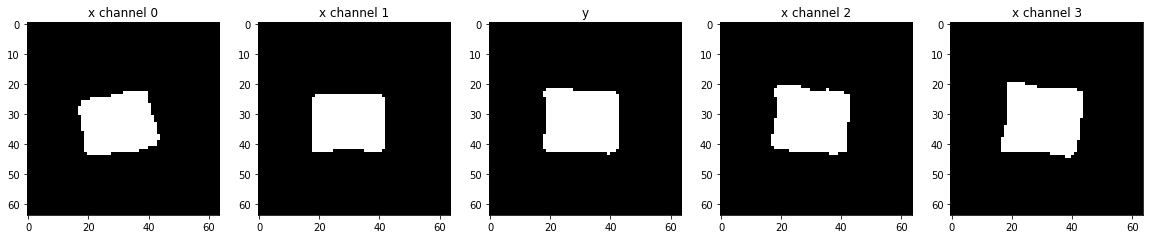

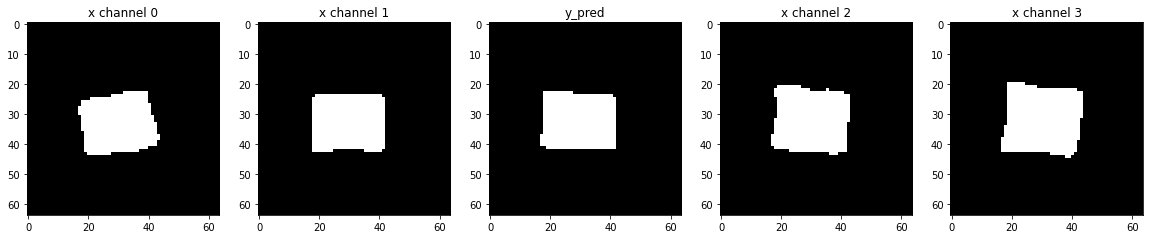

Loss: 0.015805969014763832


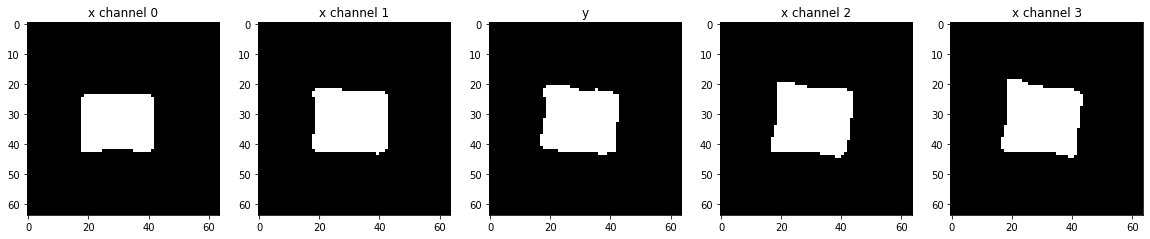

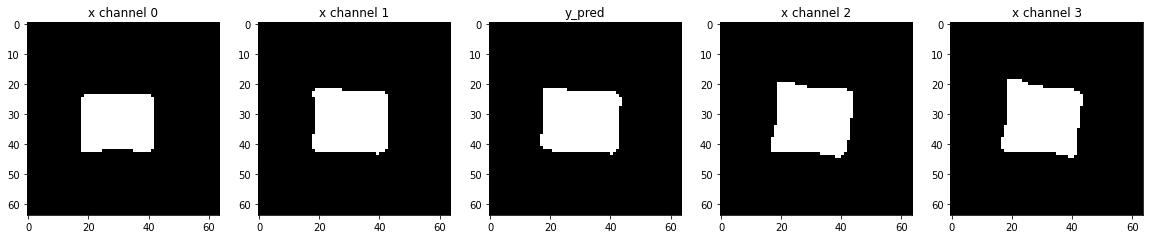

Loss: 0.016104884445667267


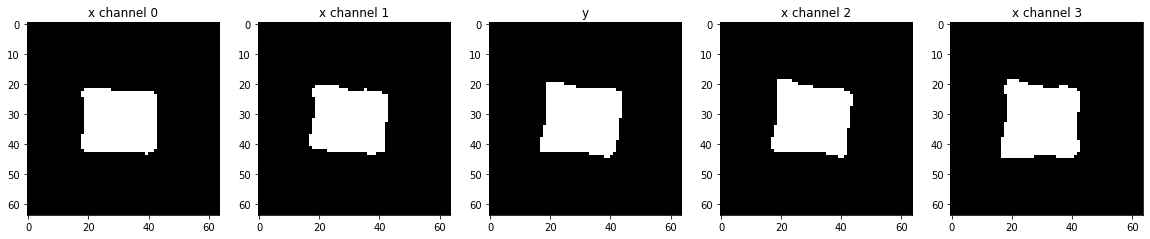

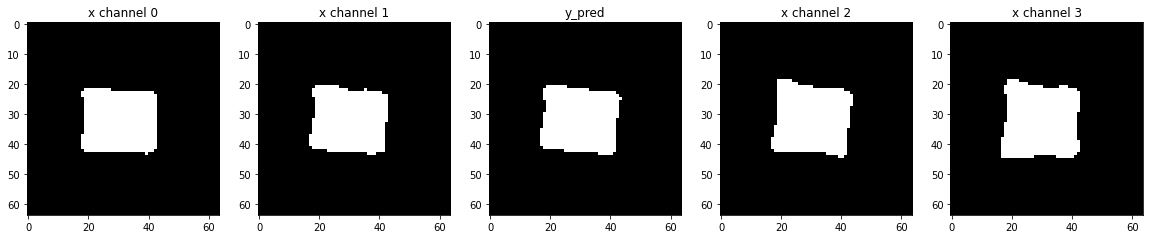

Loss: 0.019275598227977753


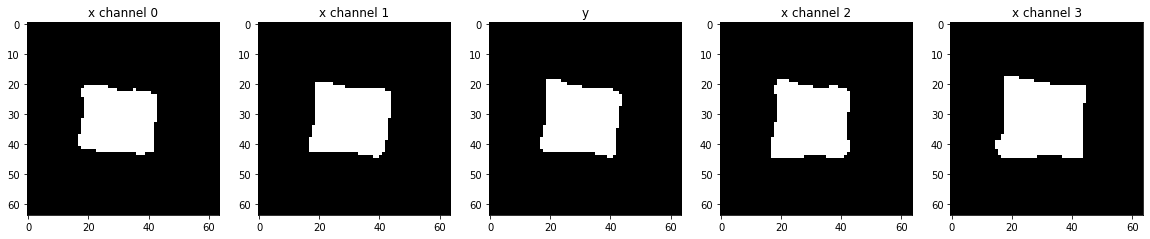

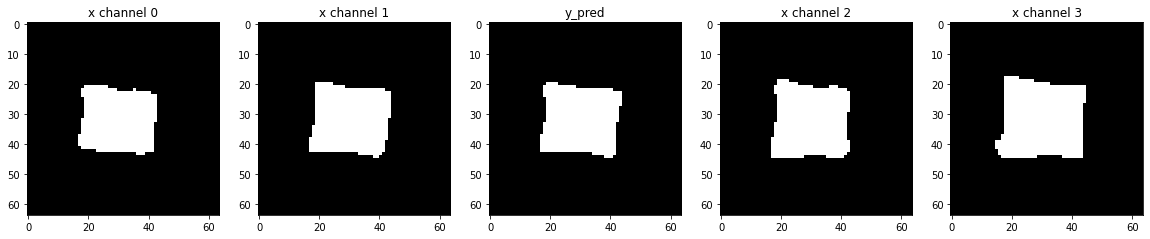

Loss: 0.02634616568684578


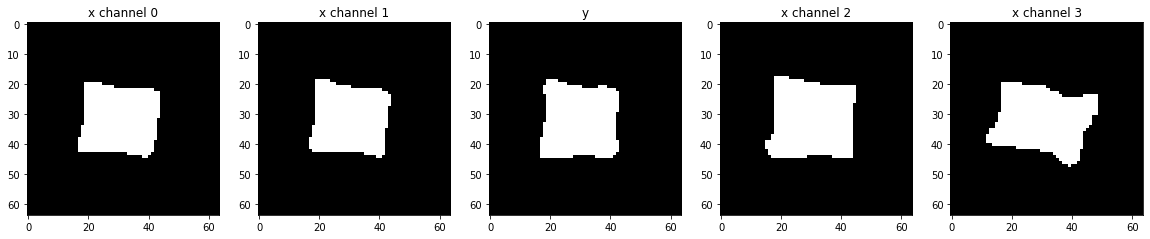

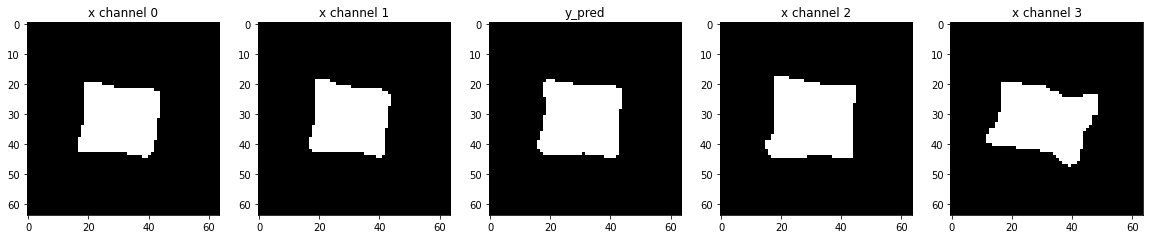

Loss: 0.033729903399944305


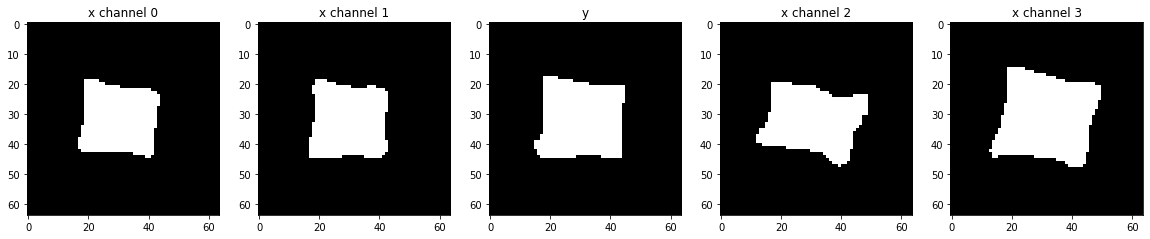

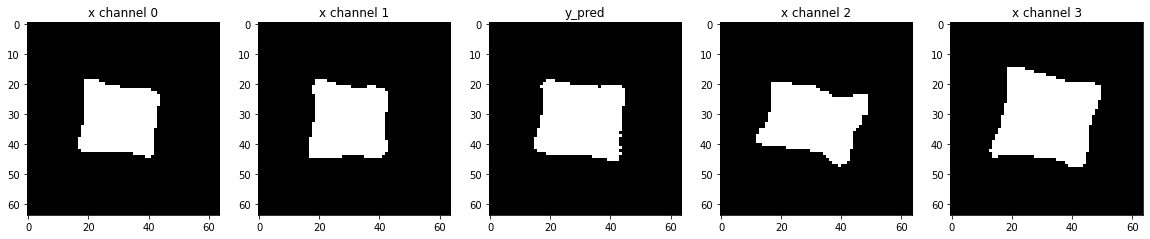

Loss: 0.05024828016757965


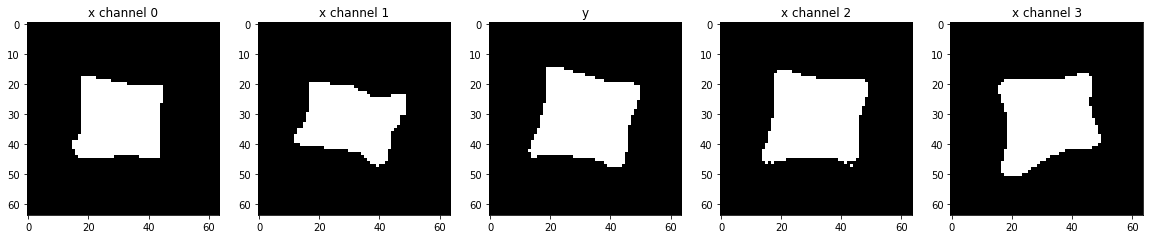

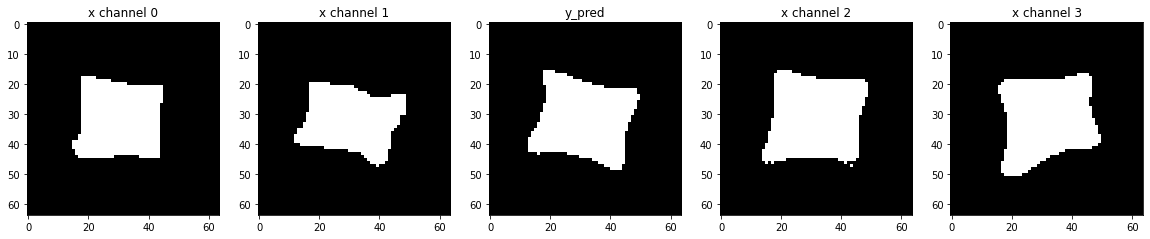

Loss: 0.040088120847940445


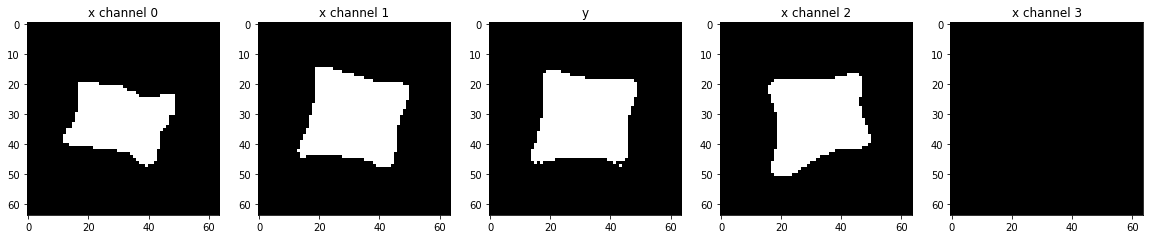

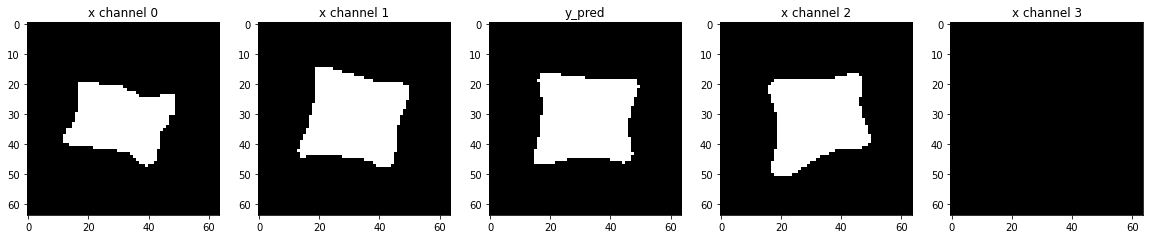

Loss: 0.05101966857910156


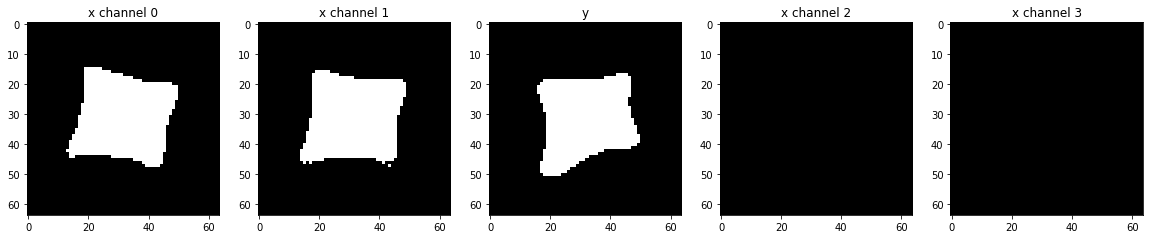

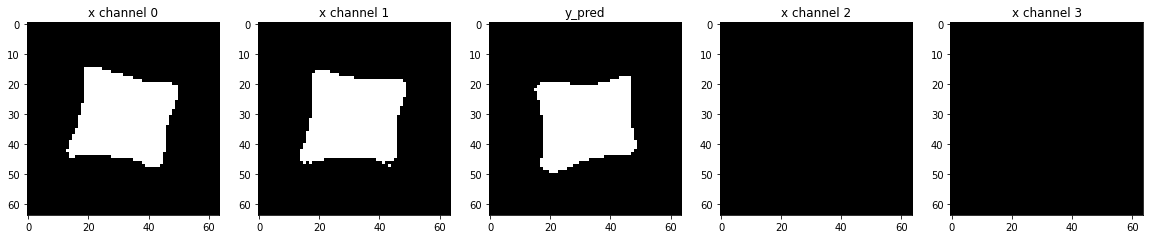

In [12]:
loss_sum = 0.0
criterion = nn.BCEWithLogitsLoss()

for x, y in test_loader:      # x is 4 input channels with neighbours, y is healthy vert to be predicted
     
    y_pred = model.forward(x.to(device))
    loss = criterion(y_pred, y.to(device))
    print('Loss: {}'.format(loss))   
    
    loss_sum += loss.item()
    y_hard = y_pred.detach() > 0
    mid_slice = x.shape[-1] // 2 

    plt.figure(figsize=(20, 8))
    plt.subplot(151)
    plt.gca().set_title('x channel 0')
    plt.imshow(x[0, 0, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.subplot(152)
    plt.gca().set_title('x channel 1')
    plt.imshow(x[0, 1, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.subplot(153)        
    plt.imshow(y[0, 0, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.title('y')
    plt.subplot(154)  
    plt.gca().set_title('x channel 2')
    plt.imshow(x[0, 2, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.subplot(155)
    plt.gca().set_title('x channel 3')
    plt.imshow(x[0, 3, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.figure(figsize=(20, 8))
    plt.subplot(151)
    plt.gca().set_title('x channel 0')
    plt.imshow(x[0, 0, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.subplot(152)
    plt.gca().set_title('x channel 1')
    plt.imshow(x[0, 1, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.subplot(153)        
    plt.imshow(y_hard[0, 0, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.title('y_pred')
    plt.subplot(154)  
    plt.gca().set_title('x channel 2')
    plt.imshow(x[0, 2, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.subplot(155)
    plt.gca().set_title('x channel 3')
    plt.imshow(x[0, 3, mid_slice, :, :].cpu().detach(), cmap='gray')
    plt.show()

In [13]:
print(loss_sum / len(test_loader))

0.03285966788285545
